## 1. Imports & Configuration

In [1]:
# Keep only used imports
import os, glob, rasterio, cupy as cp, numpy as np, pandas as pd, xgboost as xgb, logging, h5py, cProfile, seaborn as sns
import cupy.cuda.cudnn
from cupyx.scipy.ndimage import uniform_filter, generic_filter, distance_transform_edt
from statsmodels.tsa.arima.model import ARIMA 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from multiprocessing import Pool

CONFIGURATION

In [7]:
# Configuration

tiff_dir = "/home/ravl/.maps/Landuse/Watersheds/S.Lourenco/DATA/Scaled"
csv_path = "/home/ravl/.maps/Landuse/Watersheds/S.Lourenco/MPB_SAO_LOURENCO.csv"

DATA_DIR = r"/home/ravl/.maps/Landuse/Watersheds/S.Lourenco/DATA/Scaled"  # Path to GeoTIFFs
CSV_PATH = r"/home/ravl/.maps/Landuse/Watersheds/S.Lourenco/MPB_SAO_LOURENCO.csv"   # Path to CSV/JSON
OUTPUT_PATH=r"/home/ravl/.maps/Landuse/Watersheds/S.Lourenco/Predicted"
heatmap_path = r"/home/ravl/.maps/Landuse/Watersheds/S.Lourenco/Tension_And_Heatmaps"

N_YEARS = 10
GPU_ACCELERATED = True


# Logging Config
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

GPU Check

In [53]:
# Block 3: Fixed compute_neighborhood_stats for CuPy

def compute_neighborhood_stats(map_data):
    """
    Compute neighborhood statistics (mean, std, entropy) manually.
    Fixed for CuPy compatibility.
    
    Args:
        map_data (cupy.ndarray): Input land-use map.
    
    Returns:
        tuple: (mean, std, entropy) arrays.
    """
    if GPU_ACCELERATED and isinstance(map_data, cp.ndarray):
        # GPU version
        map_data = map_data.astype(cp.float32)
        from cupyx.scipy.ndimage import uniform_filter
        
        # Mean
        mean = uniform_filter(map_data, size=3)
        
        # Standard deviation
        squared_mean = uniform_filter(map_data**2, size=3)
        std = cp.sqrt(squared_mean - mean**2)
        
        # Entropy - manual implementation for GPU
        entropy = cp.zeros_like(map_data, dtype=cp.float32)
        padded = cp.pad(map_data.astype(cp.int32), pad_width=1, mode='edge')
        
        for i in range(map_data.shape[0]):
            for j in range(map_data.shape[1]):
                # Get 3x3 neighborhood
                neighborhood = padded[i:i+3, j:j+3].flatten()
                # Calculate entropy
                unique_vals, counts = cp.unique(neighborhood, return_counts=True)
                probs = counts.astype(cp.float32) / cp.sum(counts)
                # Avoid log(0)
                probs = cp.maximum(probs, 1e-10)
                entropy[i, j] = -cp.sum(probs * cp.log2(probs))
    else:
        # CPU version
        from scipy.ndimage import uniform_filter, generic_filter
        import numpy as np
        
        map_data = map_data.astype(np.float32)
        
        # Mean
        mean = uniform_filter(map_data, size=3)
        
        # Standard deviation
        squared_mean = uniform_filter(map_data**2, size=3)
        std = np.sqrt(squared_mean - mean**2)
        
        # Entropy using scipy's generic_filter
        def entropy_fn(window):
            window = window.astype(np.int32)
            counts = np.bincount(window.flatten())
            probs = counts[counts > 0] / np.sum(counts)
            probs = np.maximum(probs, 1e-10)
            return -np.sum(probs * np.log2(probs))
        
        entropy = generic_filter(map_data, entropy_fn, size=3, mode='constant', cval=0)
    
    return mean, std, entropy

In [51]:
# Block 04 GPU Check - Full

if GPU_ACCELERATED:
    try:
        print("GPU Info:")
        print(cp.show_config())
        print("GPU Memory Usage:")
        print(cp.get_default_memory_pool().used_bytes() / 1e9, "GB")
        if not cp.is_available():
            raise RuntimeError("CuPy is installed but CUDA is not accessible.")
        print("GPU acceleration is functional.")

    except Exception as e:
        print(f"GPU Error: {e}")
        GPU_ACCELERATED = False
else:
    print("GPU acceleration disabled.")


if GPU_ACCELERATED:
    from cupyx.scipy.ndimage import gaussian_filter
    print("Using Cupyx")
else:
    from scipy.ndimage import gaussian_filter
    print ("Using SciPy")

GPU Info:
OS                           : Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.35
Python Version               : 3.11.12
CuPy Version                 : 13.0.0
CuPy Platform                : NVIDIA CUDA
NumPy Version                : 1.26.4
SciPy Version                : 1.15.2
Cython Build Version         : 0.29.36
Cython Runtime Version       : 3.0.12
CUDA Root                    : /usr/local/cuda
nvcc PATH                    : /usr/local/cuda/bin/nvcc
CUDA Build Version           : 12020
CUDA Driver Version          : 12080
CUDA Runtime Version         : 12020 (linked to CuPy) / 12080 (locally installed)
cuBLAS Version               : (available)
cuFFT Version                : 11303
cuRAND Version               : 10309
cuSOLVER Version             : (11, 7, 3)
cuSPARSE Version             : (available)
NVRTC Version                : (12, 8)
Thrust Version               : 200200
CUB Build Version            : 200200
Jitify Build Version         : <unknown>
cuDNN 

## 2. Data Loading & Feature Engineering

Load

In [8]:
# Block 05 DATALOAD
def load_data():
    df = pd.read_csv(CSV_PATH)
    df['year'] = df['band'].str.extract(r'(\d{4})').astype(int)
    return df
# Check if GeoTIFFs exist
print("Checking GeoTIFF files...")
for year in range(1985, 2024):
    tif_path = f"{DATA_DIR}/{year}.tif"
    if not os.path.exists(tif_path):
        print(f"Missing file: {tif_path}")
    else:
        print(f"Found file: {tif_path}")

# Check CSV file
print("\nChecking CSV file...")
if not os.path.exists(CSV_PATH):
    print(f"Missing file: {CSV_PATH}")
else:
    print(f"Found file: {CSV_PATH}")
    df = pd.read_csv(CSV_PATH)
    print("CSV Preview:")
    print(df.head())

# Block 05 VERIFICATION
def validate_files(data_dir, csv_path, start_year=1985, end_year=2023):
    """Validate the existence of GeoTIFF and CSV files.

    Args:
        data_dir (str): Directory containing GeoTIFF files.
        csv_path (str): Path to the CSV file.
        start_year (int): Starting year for validation.
        end_year (int): Ending year for validation.

    Returns:
        tuple: (set of found years, boolean indicating CSV existence)
    """
    logger.info("Checking GeoTIFF files...")
    expected_years = set(range(start_year, end_year + 1))
    tif_files = glob.glob(f"{data_dir}/*.tif")
    found_years = {int(os.path.basename(f).split('.')[0]) for f in tif_files 
                   if os.path.basename(f).split('.')[0].isdigit()}
    missing_years = expected_years - found_years
    
    if missing_years:
        logger.warning(f"Missing files for years: {sorted(missing_years)}")
    else:
        logger.info(f"All expected GeoTIFFs ({start_year}–{end_year}) found.")
    logger.info(f"Total GeoTIFFs found: {len(found_years)}")
    
    logger.info("Checking CSV file...")
    if not os.path.exists(csv_path):
        logger.error(f"Missing file: {csv_path}")
    else:
        logger.info(f"Found file: {csv_path}")
        df = pd.read_csv(csv_path)
        logger.info(f"CSV Preview:\n{df.head()}")
    
    return found_years, os.path.exists(csv_path)

# Usage
found_years, csv_exists = validate_files(DATA_DIR, CSV_PATH)
# Usage
found_years, csv_exists = validate_files(DATA_DIR, CSV_PATH)

#Block 05 map_data shape prints
if 'map_data' in locals():
    print(f"map_data shape: {map_data.shape}")
    print(f"map_data dtype: {map_data.dtype}")
    print(f"map_data sample values:\n{map_data[:5, :5]}")
else:
    print("Error: map_data not found.")

2025-05-13 18:50:20,012 - INFO - Checking GeoTIFF files...
2025-05-13 18:50:20,013 - INFO - All expected GeoTIFFs (1985–2023) found.
2025-05-13 18:50:20,014 - INFO - Total GeoTIFFs found: 39
2025-05-13 18:50:20,014 - INFO - Checking CSV file...
2025-05-13 18:50:20,015 - INFO - Found file: /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/MPB_SAO_LOURENCO.csv
2025-05-13 18:50:20,019 - INFO - CSV Preview:
  system:index     area_km2  year  class                 band  \
0        0_0_0  5983.741658  1985      3  classification_1985   
1        0_0_1  9167.957930  1985      4  classification_1985   
2        0_0_2   979.518420  1985     11  classification_1985   
3        0_0_3   840.094316  1985     12  classification_1985   
4        0_0_4  2751.512287  1985     15  classification_1985   

                                 class_name  \
0                          Forest Formation   
1                         Savanna Formation   
2                                   Wetland   
3  Grassland (Pas

Checking GeoTIFF files...
Found file: /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/DATA/Scaled/1985.tif
Found file: /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/DATA/Scaled/1986.tif
Found file: /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/DATA/Scaled/1987.tif
Found file: /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/DATA/Scaled/1988.tif
Found file: /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/DATA/Scaled/1989.tif
Found file: /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/DATA/Scaled/1990.tif
Found file: /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/DATA/Scaled/1991.tif
Found file: /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/DATA/Scaled/1992.tif
Found file: /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/DATA/Scaled/1993.tif
Found file: /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/DATA/Scaled/1994.tif
Found file: /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/DATA/Scaled/1995.tif
Found file: /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/DATA/Scaled/1996.tif
Found file: /h

Features

Loading heatmap...
VRAM before heatmap loading: 0.000 GB
Heatmap loaded. Shape: (671, 1095)
VRAM after heatmap loading: 0.006 GB
Heatmap range: 0.00 to 1.00
Heatmap non-zero count: 205519


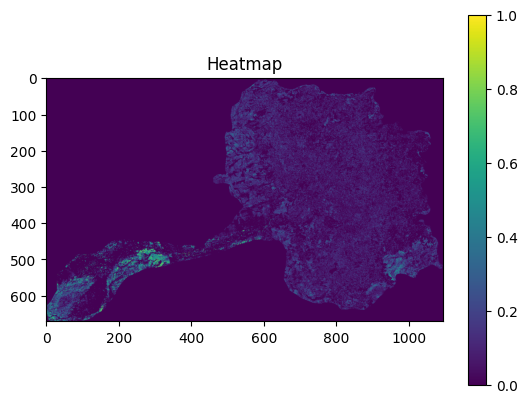

In [9]:
# Block 08: Load and normalize heatmap
print("Loading heatmap...")
print(f"VRAM before heatmap loading: {cp.get_default_memory_pool().used_bytes() / 1e9:.3f} GB")
if os.path.exists(f"{heatmap_path}/heatmap.tif"):
    try:
        with rasterio.open(f"{heatmap_path}/heatmap.tif") as src:
            heatmap = cp.asarray(src.read(1)) if GPU_ACCELERATED else src.read(1)
            heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-9)  # Avoid division by zero
            heatmap = cp.nan_to_num(heatmap, nan=0.0, posinf=0.0, neginf=0.0)
        print(f"Heatmap loaded. Shape: {heatmap.shape}")
        if GPU_ACCELERATED:
            cp.get_default_memory_pool().free_all_blocks()  # Clear any temporary memory
        print(f"VRAM after heatmap loading: {cp.get_default_memory_pool().used_bytes() / 1e9:.3f} GB")
    except Exception as e:
        print(f"Error loading heatmap: {e}")
        heatmap = None
else:
    print(f"Error: Heatmap file not found at {heatmap_path}")
    heatmap = None

if heatmap is not None:
    print(f"Heatmap range: {cp.min(heatmap):.2f} to {cp.max(heatmap):.2f}")
    print(f"Heatmap non-zero count: {cp.sum(heatmap > 0)}")
    plt.imshow(cp.asnumpy(heatmap), cmap='viridis')
    plt.title("Heatmap")
    plt.colorbar()
    plt.show()

In [10]:
def entropy_fn(window):
    """
    Compute entropy for a window of pixel values.
    
    Args:
        window: 1D array (CuPy or NumPy) representing the filter window.
    
    Returns:
        float: Entropy value (scalar).
    """
    if isinstance(window, cp.ndarray):
        counts = cp.bincount(window.flatten().astype(cp.int32))
        probs = counts / cp.sum(counts)
        return -cp.sum(probs * cp.log2(probs + 1e-9))
    else:
        counts = np.bincount(window.flatten().astype(np.int32))
        probs = counts / np.sum(counts)
        return -np.sum(probs * np.log2(probs + 1e-9))

In [11]:
def compute_neighborhood_stats(map_data):
    """
    Compute neighborhood statistics (mean, std, entropy) efficiently.
    
    Args:
        map_data: CuPy or NumPy array of the land-use map.
    
    Returns:
        tuple: (mean, std, entropy) arrays.
    """
    map_data = map_data.astype(cp.float32) if isinstance(map_data, cp.ndarray) else map_data.astype(np.float32)
    

    
    if isinstance(map_data, cp.ndarray):
        # Mean
        mean = uniform_filter(map_data, size=3)
        # Standard deviation
        squared_mean = uniform_filter(map_data**2, size=3)
        std = cp.sqrt(squared_mean - mean**2)
        # Entropy
        entropy = generic_filter(map_data, entropy_fn, size=3, mode='constant', cval=0)
    else:
        import scipy.ndimage as ndimage
        # Mean
        mean = ndimage.uniform_filter(map_data, size=3)
        # Standard deviation
        squared_mean = ndimage.uniform_filter(map_data**2, size=3)
        std = np.sqrt(squared_mean - mean**2)
        # Entropy
        entropy = ndimage.generic_filter(map_data, entropy_fn, size=3, mode='constant', cval=0)
    
    return mean, std, entropy

In [14]:
# Block 10: Enhanced Feature Extraction

def extract_features(map_data, heatmap=None, historical_maps=None):
    """
    Extract spatial and temporal features from a land-use map.
    
    Args:
        map_data: Current land use map
        heatmap: Change likelihood heatmap (already represents transition density)
        historical_maps: Dict of historical maps for temporal features
    
    Returns:
        Features array with 10 channels
    """
    logger.info("Starting enhanced feature extraction...")
    
    if map_data is None or not isinstance(map_data, (np.ndarray, cp.ndarray)):
        logger.error("Invalid map_data type: %s", type(map_data))
        return None
    
    # Validate shapes
    if heatmap is not None and hasattr(heatmap, 'shape') and map_data.shape != heatmap.shape:
        logger.error("map_data shape %s does not match heatmap shape %s", map_data.shape, heatmap.shape)
        heatmap = None
    
    if GPU_ACCELERATED:
        logger.info("VRAM before extraction: %.3f GB", cp.get_default_memory_pool().used_bytes() / 1e9)
        if not isinstance(map_data, cp.ndarray):
            map_data = cp.asarray(map_data)
        if heatmap is not None and not isinstance(heatmap, cp.ndarray):
            heatmap = cp.asarray(heatmap)
    
    # Initialize feature array with 10 channels
    features = cp.zeros((*map_data.shape, 10), dtype=cp.float32) if GPU_ACCELERATED else np.zeros((*map_data.shape, 10), dtype=np.float32)
    
    # Features 0-2: Neighborhood statistics
    logger.debug("Computing neighborhood statistics...")
    mean, std, entropy = compute_neighborhood_stats(map_data)
    features[..., 0] = cp.nan_to_num(mean, nan=0.0) if GPU_ACCELERATED else np.nan_to_num(mean, nan=0.0)
    features[..., 1] = cp.nan_to_num(std, nan=0.0) if GPU_ACCELERATED else np.nan_to_num(std, nan=0.0)
    features[..., 2] = cp.nan_to_num(entropy, nan=0.0) if GPU_ACCELERATED else np.nan_to_num(entropy, nan=0.0)
    del mean, std, entropy
    
    # Feature 3: Edge detection
    logger.debug("Computing edge detection...")
    unique_classes = cp.unique(map_data) if GPU_ACCELERATED else np.unique(map_data)
    edges = cp.zeros_like(map_data, dtype=cp.float32) if GPU_ACCELERATED else np.zeros_like(map_data, dtype=np.float32)
    for cls in unique_classes:
        if GPU_ACCELERATED:
            edges += distance_transform_edt(map_data != cls)
        else:
            from scipy.ndimage import distance_transform_edt as scipy_distance_transform_edt
            edges += scipy_distance_transform_edt(map_data != cls)
    edges /= len(unique_classes)
    features[..., 3] = cp.nan_to_num(edges, nan=0.0) if GPU_ACCELERATED else np.nan_to_num(edges, nan=0.0)
    del edges
    
    # Feature 4: Original map data
    features[..., 4] = map_data
    
    # Feature 5: Heatmap (transition density)
    if heatmap is not None:
        features[..., 5] = cp.nan_to_num(heatmap, nan=0.0) if GPU_ACCELERATED else np.nan_to_num(heatmap, nan=0.0)
        logger.info("Heatmap integrated into features")
    else:
        logger.warning("Heatmap not provided, using zeros")
        features[..., 5] = 0
    
    # Features 6-9: New temporal and spatial features
    if historical_maps and len(historical_maps) > 1:
        # Feature 6: Class stability
        logger.debug("Computing class stability...")
        features[..., 6] = compute_class_stability(map_data, historical_maps)
        
        # Feature 7: Recent change indicator
        logger.debug("Computing recent change indicator...")
        features[..., 7] = compute_recent_change_indicator(map_data, historical_maps)
    else:
        logger.warning("No historical maps provided for temporal features")
        features[..., 6] = 1.0  # Default: assume stable
        features[..., 7] = 0.0  # Default: no recent changes
    
    # Feature 8: Neighborhood heterogeneity
    logger.debug("Computing neighborhood heterogeneity...")
    features[..., 8] = compute_neighborhood_heterogeneity(map_data)
    
    # Feature 9: Distance to different class
    logger.debug("Computing distance to different class...")
    features[..., 9] = compute_distance_to_different_class(map_data)
    
    # Clear GPU memory
    if GPU_ACCELERATED:
        cp.get_default_memory_pool().free_all_blocks()
        logger.info("VRAM after extraction: %.3f GB", cp.get_default_memory_pool().used_bytes() / 1e9)
    
    logger.info("Enhanced feature extraction completed successfully")
    return features

def compute_class_stability(current_map, historical_maps):
    """Compute how many consecutive years each pixel has been its current class."""
    if GPU_ACCELERATED:
        stability_years = cp.zeros_like(current_map, dtype=cp.float32)
        current_map_gpu = cp.asarray(current_map) if not isinstance(current_map, cp.ndarray) else current_map
    else:
        stability_years = np.zeros_like(current_map, dtype=np.float32)
    
    years = sorted(historical_maps.keys(), reverse=True)  # Start from most recent
    
    for i, year in enumerate(years):
        historical_map = historical_maps[year]
        
        if GPU_ACCELERATED:
            hist_map_gpu = cp.asarray(historical_map) if not isinstance(historical_map, cp.ndarray) else historical_map
            same_class = (hist_map_gpu == current_map_gpu)
            stability_years += same_class.astype(cp.float32)
            # Stop counting where class changed
            current_map_gpu = cp.where(same_class, current_map_gpu, hist_map_gpu)
        else:
            same_class = (historical_map == current_map)
            stability_years += same_class.astype(np.float32)
            # Stop counting where class changed
            current_map = np.where(same_class, current_map, historical_map)
    
    # Normalize to [0, 1] based on maximum possible years
    max_years = len(years)
    if max_years > 0:
        stability_years = stability_years / max_years
    
    return stability_years

def compute_recent_change_indicator(current_map, historical_maps, lookback_years=5):
    """Binary indicator: has this pixel changed in recent years?"""
    years = sorted(historical_maps.keys(), reverse=True)[:lookback_years]
    
    if GPU_ACCELERATED:
        changed_recently = cp.zeros_like(current_map, dtype=cp.float32)
        current_map_gpu = cp.asarray(current_map) if not isinstance(current_map, cp.ndarray) else current_map
    else:
        changed_recently = np.zeros_like(current_map, dtype=np.float32)
    
    for year in years:
        if year in historical_maps:
            historical_map = historical_maps[year]
            
            if GPU_ACCELERATED:
                hist_map_gpu = cp.asarray(historical_map) if not isinstance(historical_map, cp.ndarray) else historical_map
                different = (hist_map_gpu != current_map_gpu).astype(cp.float32)
                changed_recently = cp.maximum(changed_recently, different)
            else:
                different = (historical_map != current_map).astype(np.float32)
                changed_recently = np.maximum(changed_recently, different)
    
    return changed_recently

def compute_neighborhood_heterogeneity(map_data):
    """
    Compute ratio of different neighboring classes.
    Careful implementation to avoid overfitting on coarse resolution.
    """
    if GPU_ACCELERATED:
        heterogeneity = cp.zeros_like(map_data, dtype=cp.float32)
        padded = cp.pad(map_data, pad_width=1, mode='edge')
    else:
        heterogeneity = np.zeros_like(map_data, dtype=np.float32)
        padded = np.pad(map_data, pad_width=1, mode='edge')
    
    # Use a sliding window approach for efficiency
    for i in range(map_data.shape[0]):
        for j in range(map_data.shape[1]):
            neighborhood = padded[i:i+3, j:j+3]
            center_class = map_data[i, j]
            
            # Count unique classes in neighborhood (excluding center)
            if GPU_ACCELERATED:
                neighbor_values = cp.concatenate([
                    neighborhood[0, :].flatten(),
                    neighborhood[1, [0, 2]].flatten(),
                    neighborhood[2, :].flatten()
                ])
                unique_neighbors = cp.unique(neighbor_values)
                # Remove center class from count if present
                unique_count = len(unique_neighbors) - (center_class in unique_neighbors)
            else:
                neighbor_values = np.concatenate([
                    neighborhood[0, :].flatten(),
                    neighborhood[1, [0, 2]].flatten(),
                    neighborhood[2, :].flatten()
                ])
                unique_neighbors = np.unique(neighbor_values)
                unique_count = len(unique_neighbors) - (center_class in unique_neighbors)
            
            # Normalize by maximum possible unique neighbors (8)
            heterogeneity[i, j] = unique_count / 8.0
    
    # Apply smoothing to reduce noise at coarse resolution
    if GPU_ACCELERATED:
        from cupyx.scipy.ndimage import gaussian_filter
        heterogeneity = gaussian_filter(heterogeneity, sigma=0.5)
    else:
        from scipy.ndimage import gaussian_filter
        heterogeneity = gaussian_filter(heterogeneity, sigma=0.5)
    
    return heterogeneity

def compute_distance_to_different_class(map_data):
    """Compute distance to nearest pixel of different class."""
    if GPU_ACCELERATED:
        distances = cp.zeros_like(map_data, dtype=cp.float32)
    else:
        distances = np.zeros_like(map_data, dtype=np.float32)
    
    unique_classes = cp.unique(map_data) if GPU_ACCELERATED else np.unique(map_data)
    
    for cls in unique_classes:
        class_mask = (map_data == cls)
        
        # Only compute for pixels of this class
        if GPU_ACCELERATED:
            if cp.any(class_mask):
                # Distance to nearest non-class pixel
                dist_to_other = distance_transform_edt(~class_mask)
                distances = cp.where(class_mask, dist_to_other, distances)
        else:
            if np.any(class_mask):
                from scipy.ndimage import distance_transform_edt as scipy_distance_transform_edt
                dist_to_other = scipy_distance_transform_edt(~class_mask)
                distances = np.where(class_mask, dist_to_other, distances)
    
    # Normalize to [0, 1]
    if GPU_ACCELERATED:
        max_dist = cp.max(distances)
        if max_dist > 0:
            distances = distances / max_dist
    else:
        max_dist = np.max(distances)
        if max_dist > 0:
            distances = distances / max_dist
    
    return distances

## 3. Transition Matrix Computation (GPU Optimized)

2025-05-14 18:41:49,592 - INFO - Computing and forecasting transition matrices with debug...
2025-05-14 18:41:49,598 - INFO - Computing and forecasting transition matrices with temporal normalization...
2025-05-14 18:41:49,714 - INFO - Classes from CSV: [3, 4, 9, 11, 12, 15, 20, 21, 24, 25, 29, 33, 39, 41, 62]
2025-05-14 18:41:49,967 - INFO - GeoTIFFs loaded for years 1985–2023
2025-05-14 18:41:49,998 - INFO - Found 15 unique classes: [0, 3, 4, 9, 11, 12, 15, 21, 24, 25, 29, 33, 39, 41, 62]
2025-05-14 18:41:50,032 - WARNING - Class 9 has no pixels in year 1985
2025-05-14 18:41:50,078 - WARNING - Class 62 has no pixels in year 1985
2025-05-14 18:41:50,111 - INFO - Saved transition matrix to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/historical_1985-1986.csv
2025-05-14 18:41:51,668 - INFO - Saved transition matrix heatmap to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/historical_1985-1986.png
2025-05-14 18:41:51,680 - WARNING - Class 9 has no 

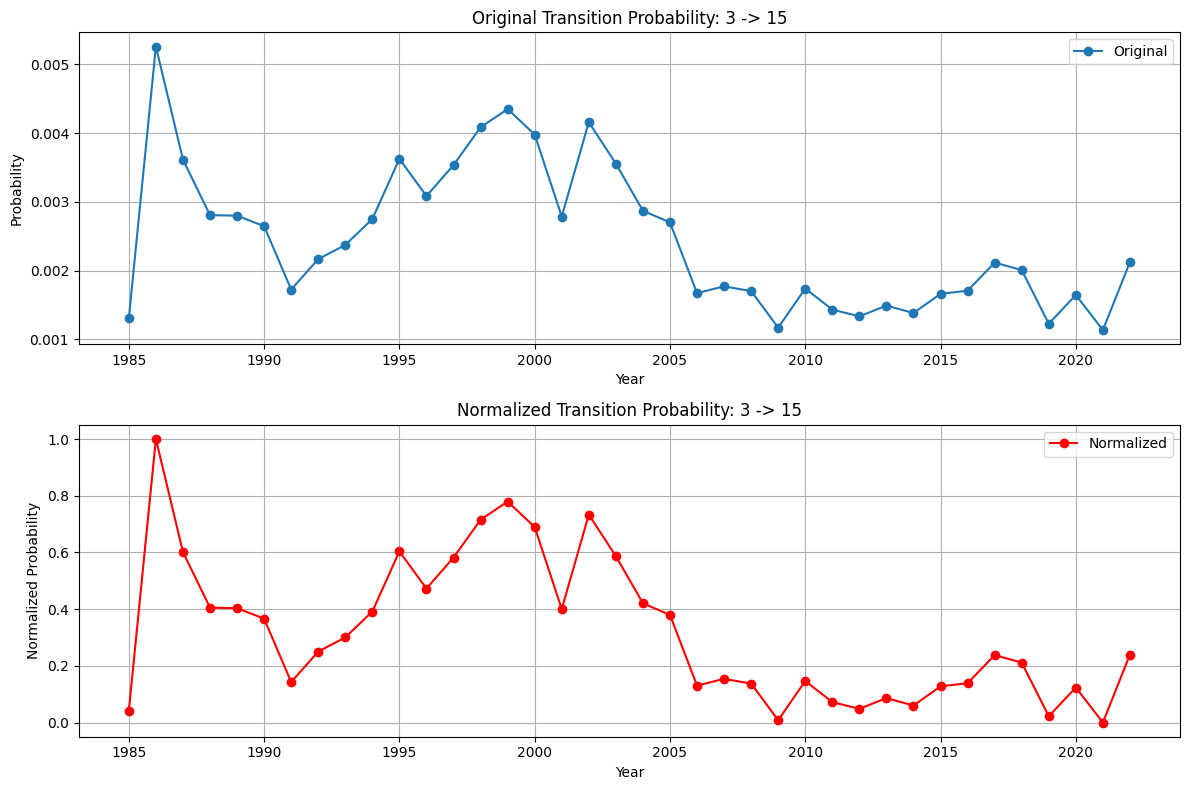

2025-05-14 18:42:21,082 - INFO - Saved transition matrix to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/forecasted_2024.csv
2025-05-14 18:42:22,543 - INFO - Saved transition matrix heatmap to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/forecasted_2024.png


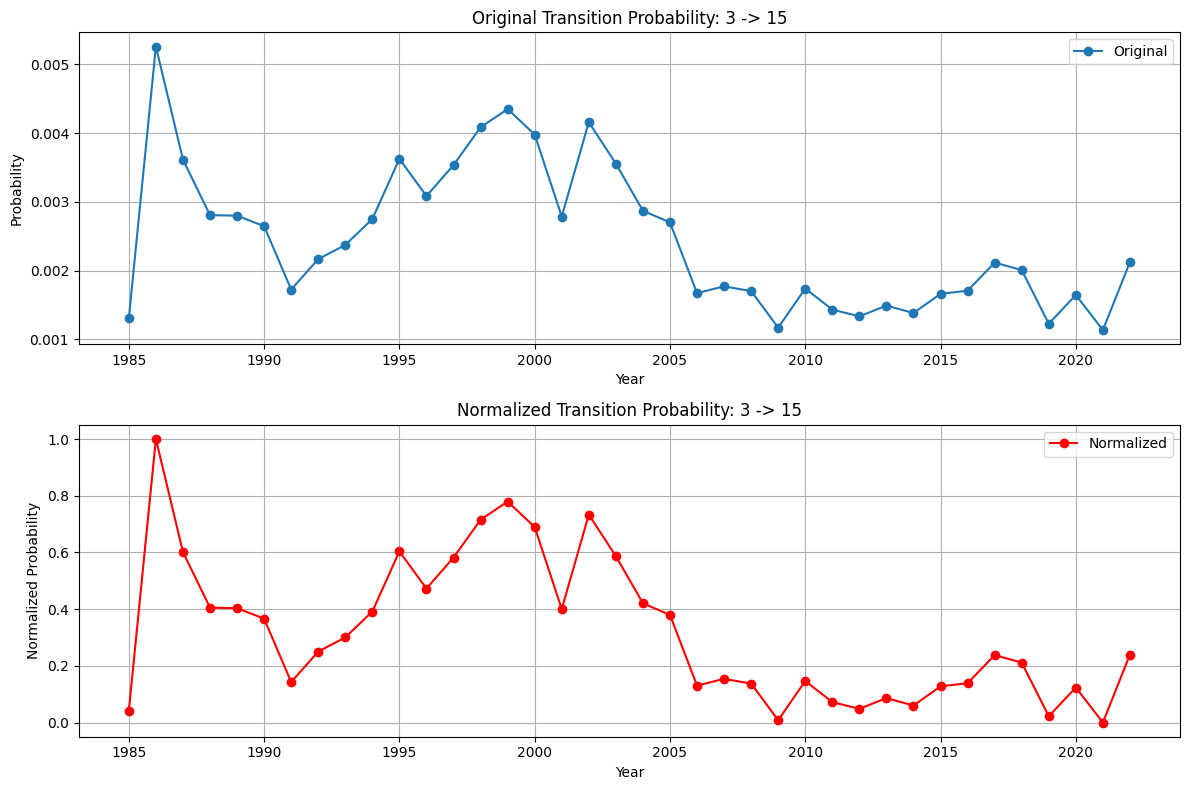

2025-05-14 18:42:22,841 - INFO - Saved transition matrix to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/forecasted_2025.csv
2025-05-14 18:42:23,425 - INFO - Saved transition matrix heatmap to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/forecasted_2025.png


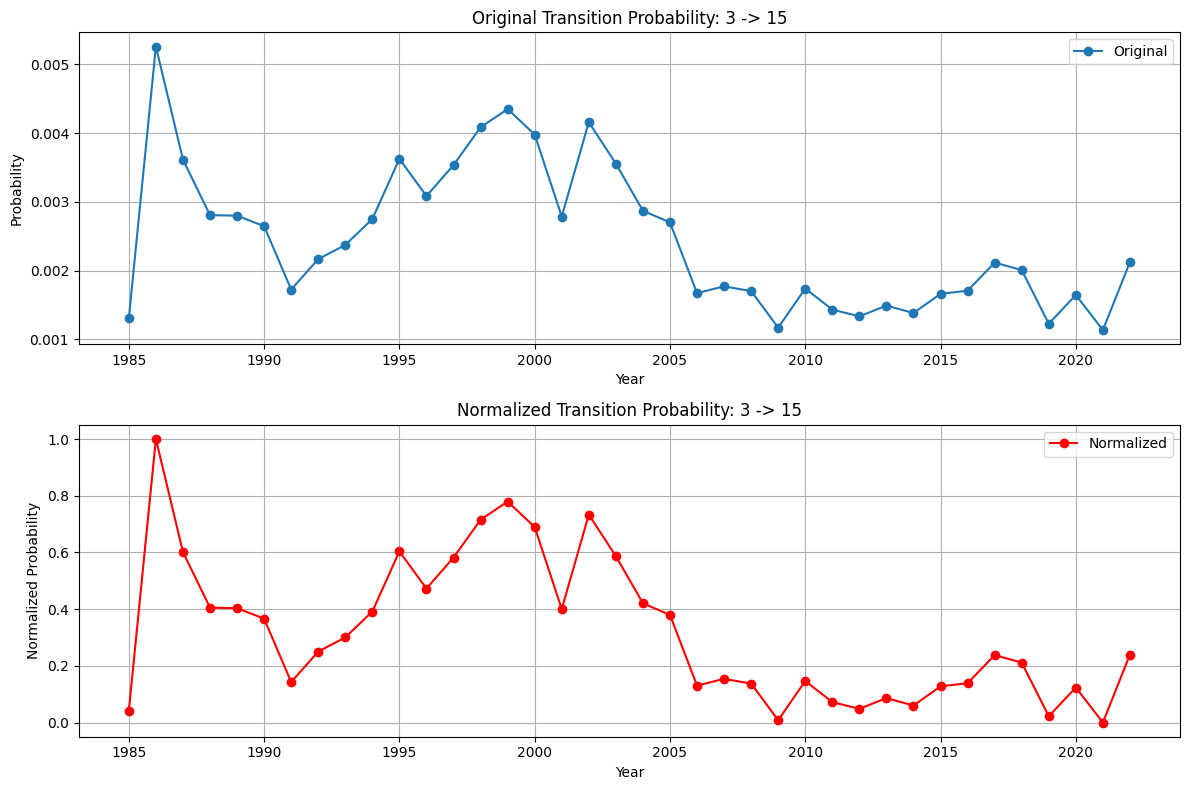

2025-05-14 18:42:23,748 - INFO - Saved transition matrix to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/forecasted_2026.csv
2025-05-14 18:42:24,461 - INFO - Saved transition matrix heatmap to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/forecasted_2026.png


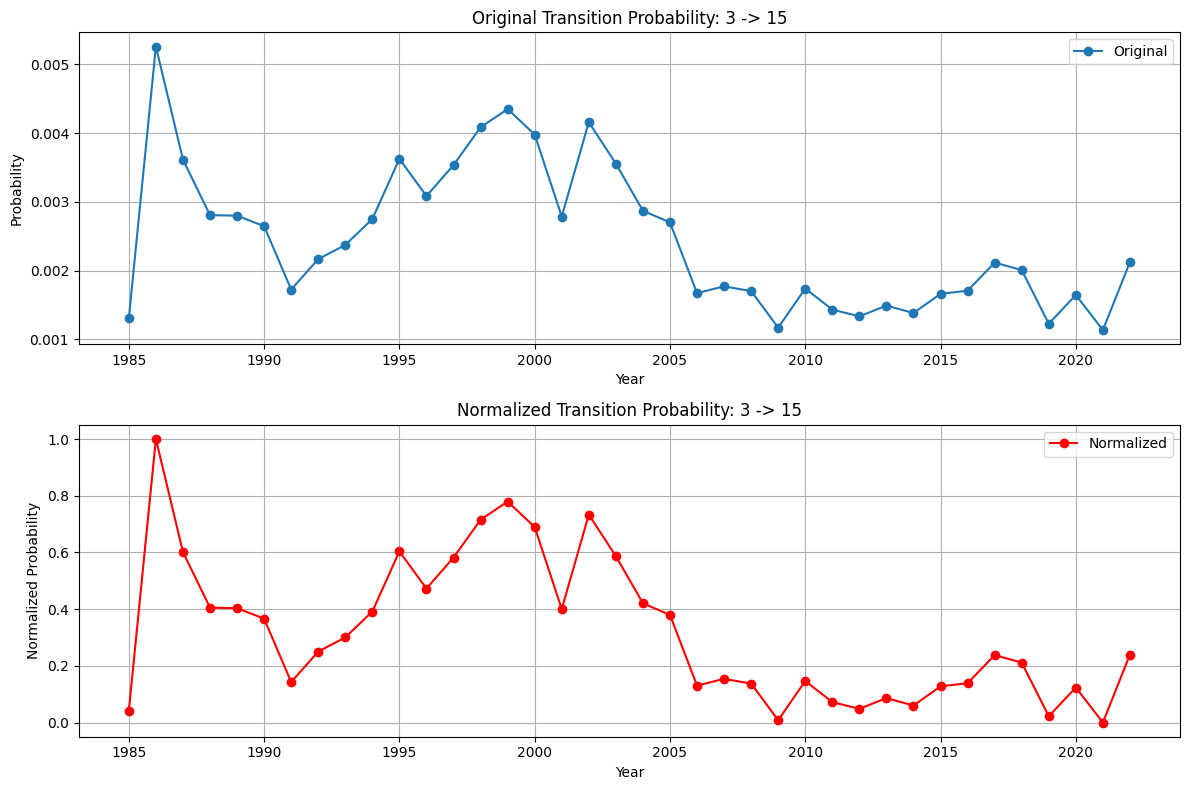

2025-05-14 18:42:24,792 - INFO - Saved transition matrix to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/forecasted_2027.csv
2025-05-14 18:42:25,464 - INFO - Saved transition matrix heatmap to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/forecasted_2027.png


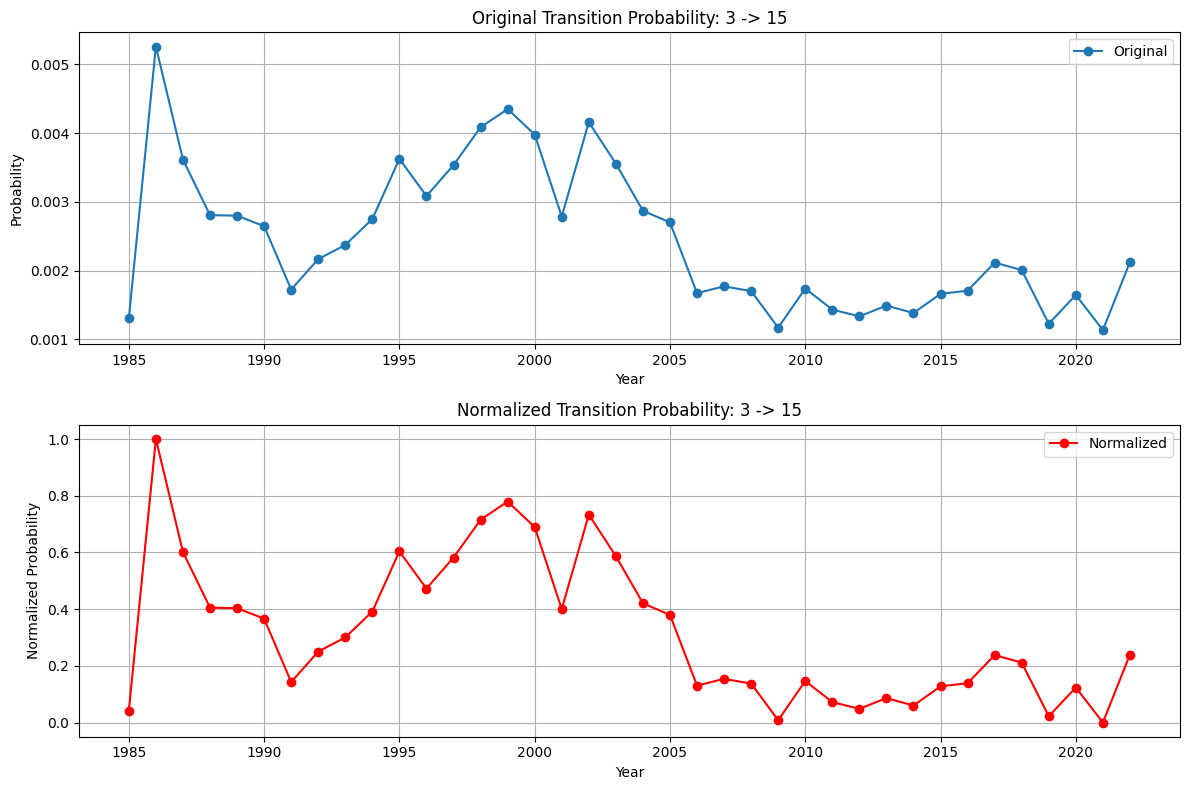

2025-05-14 18:42:26,030 - INFO - Saved transition matrix to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/forecasted_2028.csv
2025-05-14 18:42:26,788 - INFO - Saved transition matrix heatmap to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/forecasted_2028.png


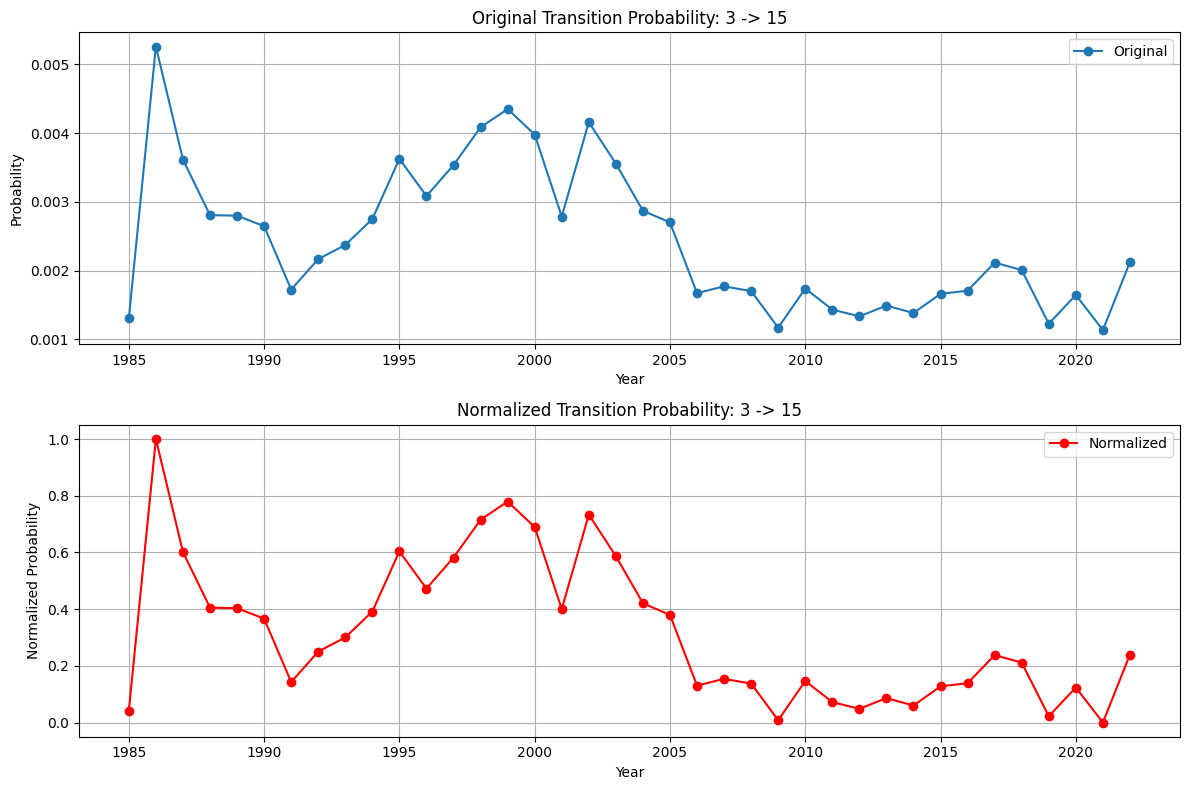

2025-05-14 18:42:27,094 - INFO - Saved transition matrix to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/forecasted_2029.csv
2025-05-14 18:42:27,703 - INFO - Saved transition matrix heatmap to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/forecasted_2029.png


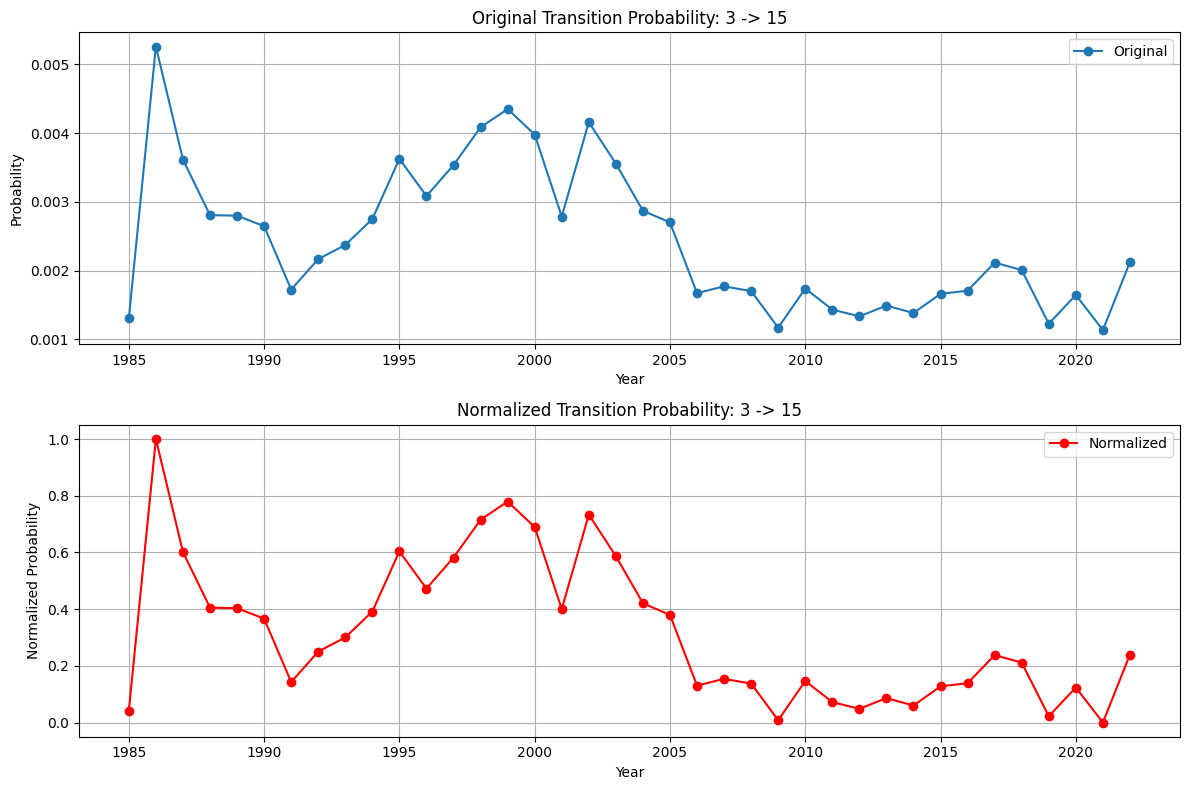

2025-05-14 18:42:27,992 - INFO - Saved transition matrix to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/forecasted_2030.csv
2025-05-14 18:42:28,665 - INFO - Saved transition matrix heatmap to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/forecasted_2030.png


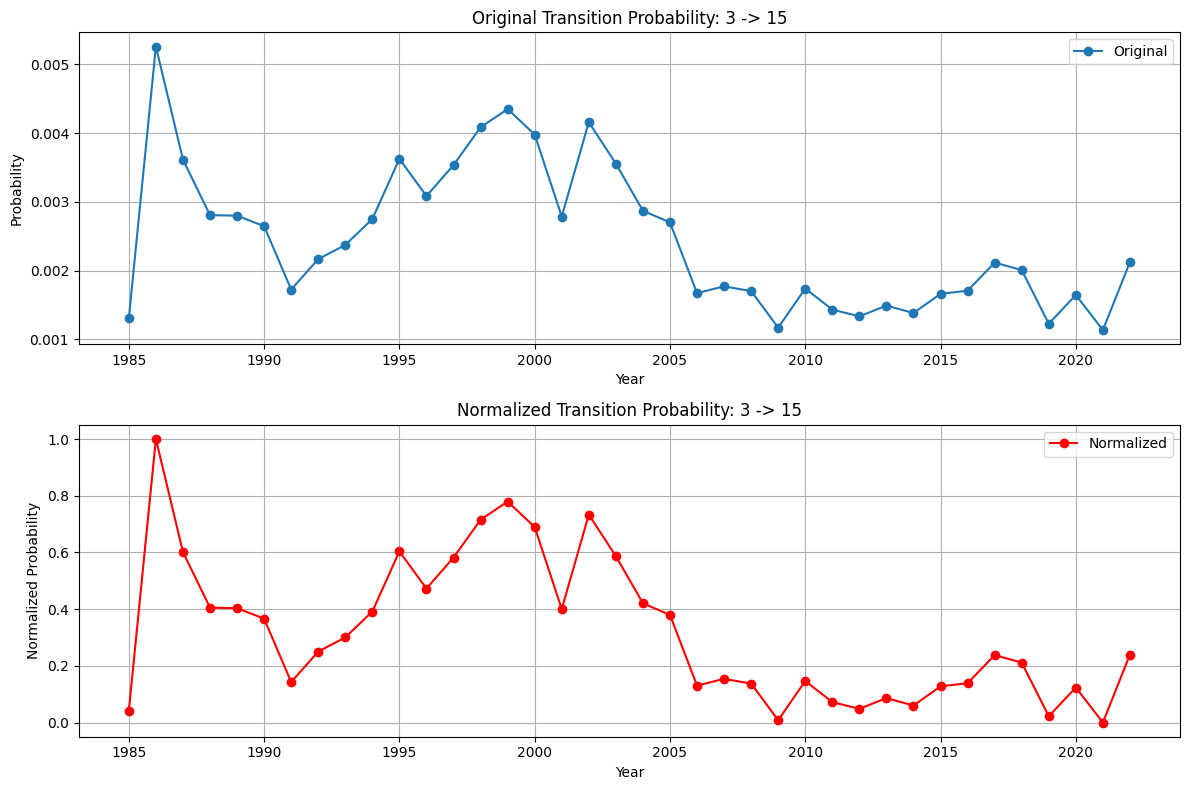

2025-05-14 18:42:28,972 - INFO - Saved transition matrix to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/forecasted_2031.csv
2025-05-14 18:42:29,823 - INFO - Saved transition matrix heatmap to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/forecasted_2031.png


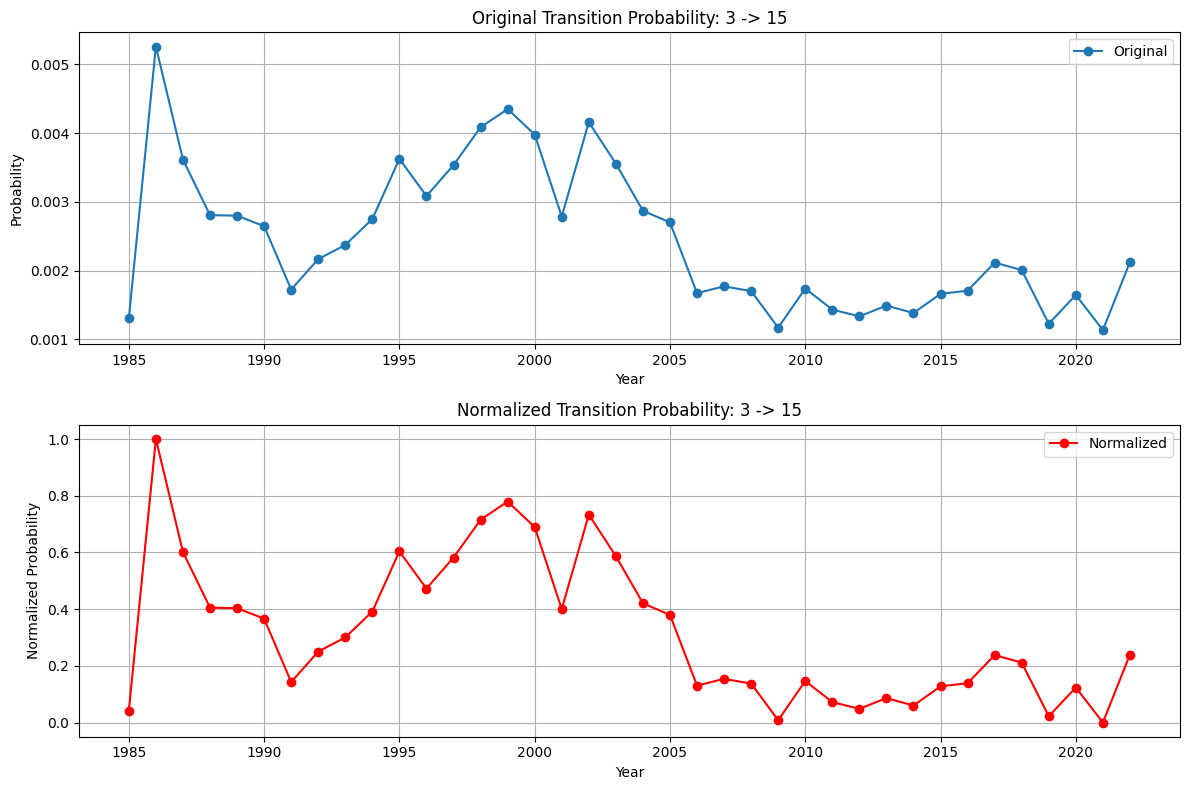

2025-05-14 18:42:30,154 - INFO - Saved transition matrix to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/forecasted_2032.csv
2025-05-14 18:42:30,854 - INFO - Saved transition matrix heatmap to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/forecasted_2032.png


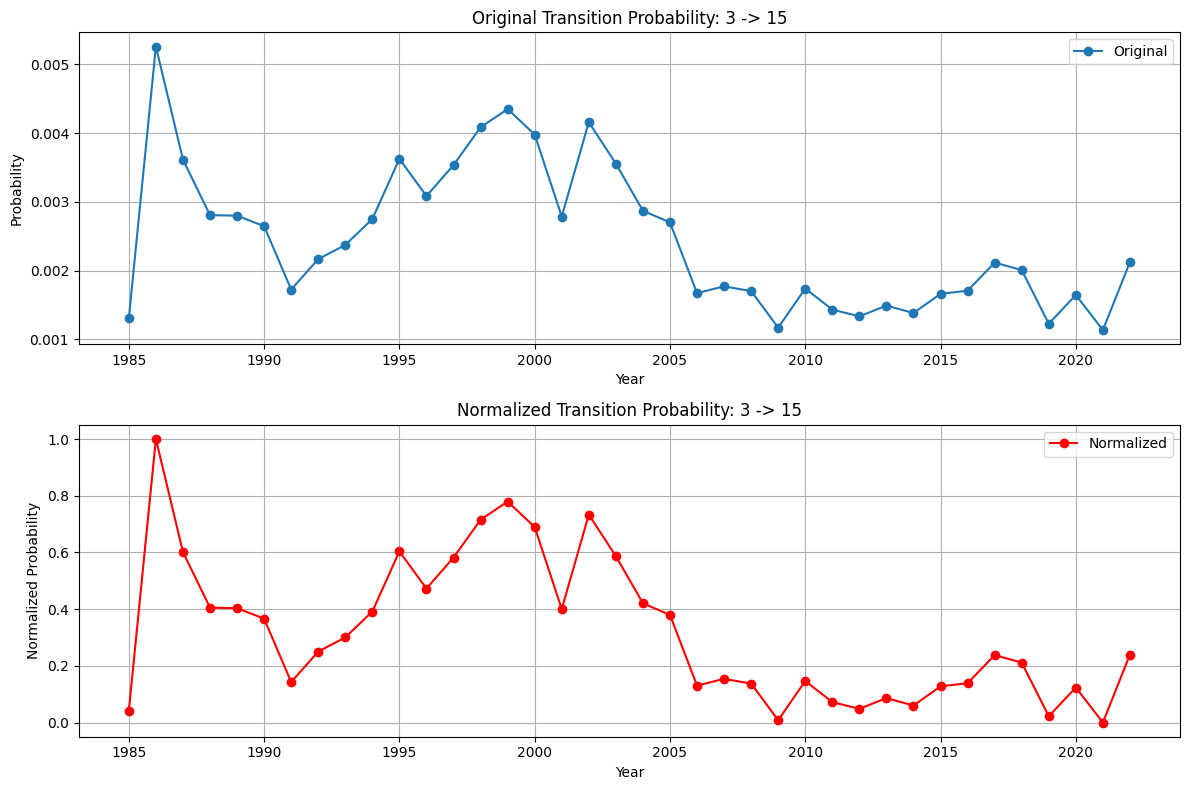

2025-05-14 18:42:31,205 - INFO - Saved transition matrix to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/forecasted_2033.csv
2025-05-14 18:42:31,849 - INFO - Saved transition matrix heatmap to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/forecasted_2033.png
2025-05-14 18:42:31,850 - INFO - Compiling all transition matrices into single CSV...
2025-05-14 18:42:31,912 - INFO - Saved compilation to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/all_transitions_compilation.csv
2025-05-14 18:42:32,202 - INFO - Saved summary statistics to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/all_transitions_compilation_summary.csv
2025-05-14 18:42:32,222 - INFO - Transition matrix forecasting with normalization completed
2025-05-14 18:42:32,223 - INFO - Transition matrix forecasting succeeded


In [32]:
#Block 11 - Transition Matrix with Temporal Normalization and Outlier Handling

def save_transition_matrix(matrix, filename_prefix, unique_classes, output_dir="/home/ravl/.maps/Watersheds/Landuse/S.Lourenco/TransitionMatrices"):
    """
    Save a transition matrix as a CSV and a heatmap visualization.
    
    Args:
        matrix (numpy.ndarray): Transition matrix to save.
        filename_prefix (str): Prefix for the filename (e.g., "historical_1985-1986", "mean_average", "forecasted_2024").
        unique_classes (list): List of unique class labels.
        output_dir (str): Directory to save the files.
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Convert CuPy to NumPy if necessary
    matrix_np = cp.asnumpy(matrix) if isinstance(matrix, cp.ndarray) else matrix
    
    # Save as CSV
    csv_path = os.path.join(output_dir, f"{filename_prefix}.csv")
    df = pd.DataFrame(matrix_np, index=unique_classes, columns=unique_classes)
    df.to_csv(csv_path)
    logger.info("Saved transition matrix to %s", csv_path)
    
    # Save as heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_np, annot=True, fmt=".3f", cmap="YlOrRd", 
                xticklabels=unique_classes, yticklabels=unique_classes)
    plt.title(f"Transition Matrix: {filename_prefix}")
    plt.xlabel("To Class")
    plt.ylabel("From Class")
    heatmap_path = os.path.join(output_dir, f"{filename_prefix}.png")
    plt.savefig(heatmap_path, dpi=300, bbox_inches="tight")
    plt.close()
    logger.info("Saved transition matrix heatmap to %s", heatmap_path)

import cupy as cp
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
import os
import rasterio

# Assuming global variables from your notebook
DATA_DIR = r"/home/ravl/.maps/Landuse/Watersheds/S.Lourenco/DATA/Scaled"
CSV_PATH = r"/home/ravl/.maps/Landuse/Watersheds/S.Lourenco/MPB_SAO_LOURENCO.csv"
GPU_ACCELERATED = True
logger = logging.getLogger(__name__)

def save_transition_matrix(matrix, filename_prefix, unique_classes, output_dir="/home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices"):
    """Save a transition matrix as a CSV and a heatmap visualization."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    matrix_np = cp.asnumpy(matrix) if isinstance(matrix, cp.ndarray) else matrix
    csv_path = os.path.join(output_dir, f"{filename_prefix}.csv")
    df = pd.DataFrame(matrix_np, index=unique_classes, columns=unique_classes)
    df.to_csv(csv_path)
    logger.info("Saved transition matrix to %s", csv_path)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_np, annot=True, fmt=".3f", cmap="YlOrRd", 
                xticklabels=unique_classes, yticklabels=unique_classes)
    plt.title(f"Transition Matrix: {filename_prefix}")
    plt.xlabel("To Class")
    plt.ylabel("From Class")
    heatmap_path = os.path.join(output_dir, f"{filename_prefix}.png")
    plt.savefig(heatmap_path, dpi=300, bbox_inches="tight")
    plt.close()
    logger.info("Saved transition matrix heatmap to %s", heatmap_path)

def save_all_transition_matrices(historical_matrices, forecasted_matrices, unique_classes, 
                               output_file="all_transition_matrices_compilation.csv"):
    """
    Save all transition matrices (historical and forecasted) into a single CSV file for analysis.
    Each row represents one transition (from->to) across all years.
    """
    logger.info("Compiling all transition matrices into single CSV...")
    
    # Create a list to hold all data
    all_data = []
    
    # Convert historical matrices from CuPy to NumPy if needed
    if isinstance(historical_matrices[0], cp.ndarray):
        historical_matrices_np = [matrix.get() for matrix in historical_matrices]
    else:
        historical_matrices_np = historical_matrices
    
    # Process historical matrices (1985-2023)
    for year_idx, matrix in enumerate(historical_matrices_np):
        year = 1985 + year_idx
        for i, from_class in enumerate(unique_classes):
            for j, to_class in enumerate(unique_classes):
                probability = matrix[i, j]
                all_data.append({
                    'year': year,
                    'from_class': from_class,
                    'to_class': to_class,
                    'probability': probability,
                    'type': 'historical'
                })
    
    # Process forecasted matrices (2024-2033)
    for year, matrix in forecasted_matrices.items():
        # Convert from CuPy if needed
        if isinstance(matrix, cp.ndarray):
            matrix_np = matrix.get()
        else:
            matrix_np = matrix
            
        for i, from_class in enumerate(unique_classes):
            for j, to_class in enumerate(unique_classes):
                probability = matrix_np[i, j]
                all_data.append({
                    'year': year,
                    'from_class': from_class,
                    'to_class': to_class,
                    'probability': probability,
                    'type': 'forecasted'
                })
    
    # Create DataFrame and save
    df = pd.DataFrame(all_data)
    
    # Add a transition identifier for easy filtering
    df['transition'] = df['from_class'].astype(str) + '->' + df['to_class'].astype(str)
    
    # Sort by transition and year for better readability
    df = df.sort_values(['from_class', 'to_class', 'year'])
    
    # Save to CSV
    df.to_csv(output_file, index=False)
    logger.info(f"Saved compilation to {output_file}")
    
    # Also create a summary statistics file
    summary_file = output_file.replace('.csv', '_summary.csv')
    
    # Calculate statistics for each transition
    summary_data = []
    for from_class in unique_classes:
        for to_class in unique_classes:
            transition_data = df[(df['from_class'] == from_class) & (df['to_class'] == to_class)]
            
            if len(transition_data) > 0:
                historical_data = transition_data[transition_data['type'] == 'historical']['probability']
                forecasted_data = transition_data[transition_data['type'] == 'forecasted']['probability']
                
                summary_data.append({
                    'transition': f"{from_class}->{to_class}",
                    'from_class': from_class,
                    'to_class': to_class,
                    'historical_mean': historical_data.mean() if len(historical_data) > 0 else 0,
                    'historical_std': historical_data.std() if len(historical_data) > 0 else 0,
                    'historical_min': historical_data.min() if len(historical_data) > 0 else 0,
                    'historical_max': historical_data.max() if len(historical_data) > 0 else 0,
                    'forecasted_mean': forecasted_data.mean() if len(forecasted_data) > 0 else 0,
                    'forecasted_std': forecasted_data.std() if len(forecasted_data) > 0 else 0,
                    'forecasted_min': forecasted_data.min() if len(forecasted_data) > 0 else 0,
                    'forecasted_max': forecasted_data.max() if len(forecasted_data) > 0 else 0,
                    'change_in_mean': (forecasted_data.mean() - historical_data.mean()) if len(forecasted_data) > 0 and len(historical_data) > 0 else 0
                })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(summary_file, index=False)
    logger.info(f"Saved summary statistics to {summary_file}")
    
    return df, summary_df

def compute_transition_matrix_forecast(start_year=2024, end_year=2033, debug_from_class=None, debug_to_class=None):
    """
    Compute historical transition matrices, mean average, and forecast for future years using ARIMA with temporal normalization.
    
    Args:
        start_year (int): Start year for forecasting.
        end_year (int): End year for forecasting.
        debug_from_class (int, optional): Class ID to debug (from-class).
        debug_to_class (int, optional): Class ID to debug (to-class).
    
    Returns:
        dict: Year-specific forecasted transition matrices.
        list: Unique classes.
        dict: Class-to-index mapping.
    """
    logger.info("Computing and forecasting transition matrices with temporal normalization...")
    
    # Load CSV to validate class IDs
    df = pd.read_csv(CSV_PATH)
    csv_classes = sorted(df['class'].unique())
    logger.info(f"Classes from CSV: {csv_classes}")
    
    # Validate debug class IDs
    if debug_from_class is not None and debug_to_class is not None:
        if debug_from_class not in csv_classes or debug_to_class not in csv_classes:
            logger.warning(f"Debug classes ({debug_from_class}, {debug_to_class}) not found in CSV. Disabling debug plot.")
            debug_from_class = debug_to_class = None
    
    # Load historical maps (1985–2023)
    maps = {}
    for year in range(1985, 2024):
        tif_path = f"{DATA_DIR}/{year}.tif"
        if not os.path.exists(tif_path):
            logger.error("File not found: %s", tif_path)
            return None, None, None
        with rasterio.open(tif_path) as src:
            maps[year] = cp.asarray(src.read(1))
    
    logger.info("GeoTIFFs loaded for years 1985–2023")
    unique_classes = cp.unique(maps[2023]).tolist()
    n_classes = len(unique_classes)
    class_to_index = {cls: idx for idx, cls in enumerate(unique_classes)}
    logger.info("Found %d unique classes: %s", n_classes, unique_classes)
    
    # Compute historical transition matrices
    historical_matrices = []
    for year in range(1985, 2023):
        map_current = maps[year]
        map_next = maps[year + 1]
        if map_current.shape != map_next.shape:
            logger.error("Shape mismatch between %d.tif %s and %d.tif %s", year, map_current.shape, year+1, map_next.shape)
            return None, None, None
        
        trans_matrix = cp.zeros((n_classes, n_classes), dtype=cp.float32)
        for i, cls_current in enumerate(unique_classes):
            mask = (map_current == cls_current)
            if cp.sum(mask) == 0:
                logger.warning("Class %d has no pixels in year %d", cls_current, year)
                continue
            for j, cls_next in enumerate(unique_classes):
                trans_matrix[i, j] = cp.sum(mask & (map_next == cls_next))
        
        row_sums = trans_matrix.sum(axis=1, keepdims=True)
        trans_matrix = cp.where(row_sums > 0, trans_matrix / row_sums, cp.eye(n_classes))
        historical_matrices.append(trans_matrix)  # Keep as CuPy array
        save_transition_matrix(trans_matrix, f"historical_{year}-{year+1}", unique_classes)
    
    if not historical_matrices:
        logger.error("No historical transition matrices computed")
        return None, None, None
    
    # Compute mean average matrix with exponential weighting
    weights = cp.exp(cp.arange(len(historical_matrices)) * 0.1)
    weights /= weights.sum()
    mean_trans_matrix = cp.average(cp.stack(historical_matrices), axis=0, weights=weights)
    
    # Apply boost for rare classes
    pixel_counts = {0: 411951, 3: 62743, 4: 61544, 9: 2166, 11: 6902, 12: 14909, 
                    15: 93754, 21: 29246, 24: 1519, 25: 1798, 29: 3386, 33: 1519, 
                    39: 40175, 41: 2838, 62: 295}
    for cls, count in pixel_counts.items():
        if count < 2000 and cls in class_to_index:
            idx = class_to_index[cls]
            mean_trans_matrix[idx] *= 1.1
    mean_trans_matrix /= cp.sum(mean_trans_matrix, axis=1, keepdims=True)
    save_transition_matrix(mean_trans_matrix, "mean_average", unique_classes)
    
    # Convert to numpy for normalization and ARIMA
    historical_matrices_np = [matrix.get() for matrix in historical_matrices]
    historical_matrices = np.array(historical_matrices_np)  # Shape: (n_years, n_classes, n_classes)
    
    # Compute normalization factors for each transition
    logger.info("Computing normalization factors for temporal trends...")
    normalization_factors = np.zeros((n_classes, n_classes, 2))  # [min, max] for each transition
    
    for i in range(n_classes):
        for j in range(n_classes):
            time_series = historical_matrices[:, i, j]
            if np.any(time_series > 0):  # Only normalize non-zero transitions
                series_min = np.min(time_series[time_series > 0])  # Min non-zero value
                series_max = np.max(time_series)
                normalization_factors[i, j] = [series_min, series_max]
            else:
                normalization_factors[i, j] = [0, 1]  # Default for zero transitions
    
    # Normalize historical matrices for ARIMA
    normalized_historical = np.zeros_like(historical_matrices)
    for t in range(historical_matrices.shape[0]):
        for i in range(n_classes):
            for j in range(n_classes):
                min_val, max_val = normalization_factors[i, j]
                if max_val > min_val:
                    # Normalize to [0, 1] range
                    normalized_historical[t, i, j] = (historical_matrices[t, i, j] - min_val) / (max_val - min_val)
                else:
                    normalized_historical[t, i, j] = historical_matrices[t, i, j]
    
    # Analyze transition patterns
    logger.info("Analyzing transition patterns before ARIMA...")
    transitions_with_trends = []
    
    for i in range(n_classes):
        for j in range(n_classes):
            time_series = historical_matrices[:, i, j]
            normalized_series = normalized_historical[:, i, j]
            
            if np.any(time_series > 0):
                # Calculate trend metrics
                non_zero_count = np.sum(time_series > 0)
                original_std = np.std(time_series)
                normalized_std = np.std(normalized_series)
                
                # Linear regression to detect trend
                if non_zero_count > 5:
                    years = np.arange(len(time_series))
                    slope, intercept, r_value, p_value, std_err = stats.linregress(years, normalized_series)
                    
                    # Log significant trends
                    if abs(slope) > 0.01 or normalized_std > 0.05:
                        transitions_with_trends.append((i, j, slope, normalized_std, r_value**2))
                        logger.info(f"Transition {unique_classes[i]}->{unique_classes[j]}: "
                                  f"slope={slope:.4f}, std={normalized_std:.4f}, R²={r_value**2:.4f}")
    
    logger.info(f"Found {len(transitions_with_trends)} transitions with detectable trends")
    
    # Identify outlier transitions
    logger.info("Identifying outlier transitions...")
    outlier_transitions = []
    for i in range(n_classes):
        for j in range(n_classes):
            normalized_series = normalized_historical[:, i, j]
            std_val = np.std(normalized_series)
            if std_val > 1.0:  # Flag extreme standard deviations
                outlier_transitions.append((i, j, std_val))
                logger.warning(f"Outlier transition {unique_classes[i]}->{unique_classes[j]}: std={std_val:.4f}")
    
    # Get debug indices if specified
    debug_i = class_to_index[debug_from_class] if debug_from_class is not None else None
    debug_j = class_to_index[debug_to_class] if debug_to_class is not None else None
    
    # Forecast transition matrices
    forecasted_matrices = {}
    
    for year in range(start_year, end_year + 1):
        forecasted_matrix = np.zeros((n_classes, n_classes), dtype=np.float32)
        
        for i in range(n_classes):
            for j in range(n_classes):
                time_series = historical_matrices[:, i, j]
                normalized_series = normalized_historical[:, i, j]
                min_val, max_val = normalization_factors[i, j]
                
                # Check if this is an outlier
                is_outlier = any(oi == i and oj == j for oi, oj, _ in outlier_transitions)
                
                # Debug plot for specified i, j
                if debug_i is not None and debug_j is not None and i == debug_i and j == debug_j:
                    plt.figure(figsize=(12, 8))
                    
                    # Plot original time series
                    plt.subplot(2, 1, 1)
                    plt.plot(range(1985, 2023), time_series, marker='o', label='Original')
                    plt.title(f'Original Transition Probability: {unique_classes[i]} -> {unique_classes[j]}')
                    plt.xlabel('Year')
                    plt.ylabel('Probability')
                    plt.grid(True)
                    plt.legend()
                    
                    # Plot normalized time series
                    plt.subplot(2, 1, 2)
                    plt.plot(range(1985, 2023), normalized_series, marker='o', color='red', label='Normalized')
                    plt.title(f'Normalized Transition Probability: {unique_classes[i]} -> {unique_classes[j]}')
                    plt.xlabel('Year')
                    plt.ylabel('Normalized Probability')
                    plt.grid(True)
                    plt.legend()
                    
                    plt.tight_layout()
                    plt.show()
                
                if np.all(time_series == 0) or np.all(time_series == 1):
                    forecasted_matrix[i, j] = time_series[-1]
                    continue
                
                non_zero_count = np.sum(time_series > 0)
                normalized_std = np.std(normalized_series)
                
                # Get slope from linear regression
                if non_zero_count > 5:
                    years_array = np.arange(len(time_series))
                    slope, intercept, r_value, _, _ = stats.linregress(years_array, normalized_series)
                else:
                    slope = 0
                    r_value = 0
                
                success = False
                
                # For outliers, use more robust methods
                if is_outlier:
                    try:
                        # Use median-based approach for outliers
                        recent_values = time_series[-5:]
                        forecasted_matrix[i, j] = np.median(recent_values)
                        success = True
                        logger.debug(f"Outlier {i}->{j}: Used median approach")
                    except:
                        pass
                
                # For transitions with clear trends (high R² and reasonable std)
                elif abs(r_value) > 0.2 and normalized_std < 1.0 and non_zero_count > 8:
                    try:
                        # Use linear extrapolation for clear trends
                        future_index = len(years_array) + (year - 2023) - 1
                        normalized_forecast = intercept + slope * future_index
                        normalized_forecast = np.clip(normalized_forecast, 0, 1)
                        forecasted_value = normalized_forecast * (max_val - min_val) + min_val
                        forecasted_matrix[i, j] = max(0, min(1, forecasted_value))
                        success = True
                        logger.debug(f"Transition {i}->{j}: Used linear trend (R²={r_value**2:.3f})")
                    except:
                        pass
                
                # Standard ARIMA for moderate variations
                elif not success and normalized_std > 0.02 and non_zero_count > 8:
                    try:
                        # Try ARIMA with more conservative parameters
                        model = ARIMA(normalized_series, order=(1, 0, 0))
                        model_fit = model.fit(
                            method='lbfgs',  # More stable optimizer
                            maxiter=1000,
                            disp=False
                        )
                        
                        if model_fit.mle_retvals['converged']:
                            steps = (year - 2023)
                            normalized_forecast = model_fit.forecast(steps=steps)
                            forecasted_value = normalized_forecast[-1] * (max_val - min_val) + min_val
                            forecasted_matrix[i, j] = max(0, min(1, forecasted_value))
                            success = True
                            logger.debug(f"Transition {i}->{j}: ARIMA successful")
                    except Exception as e:
                        logger.debug(f"ARIMA failed for {i}->{j}: {str(e)}")
                else:
                    logger.debug(f"Transition {i}->{j} rejected linear: R²={r_value**2:.3f} (need >0.04), "
                    f"std={normalized_std:.3f} (need <1.0), count={non_zero_count} (need >8)")
                
                # Fallback for all other cases
                if not success:
                    # Use exponentially weighted average
                    recent_years = min(5, len(time_series))
                    weights = np.exp(np.arange(recent_years) * 0.3)
                    weights = weights / weights.sum()
                    recent_values = time_series[-recent_years:]
                    forecasted_matrix[i, j] = np.average(recent_values, weights=weights)
                    logger.debug(f"Transition {i}->{j}: Used weighted average fallback")
        
        # Normalize rows to sum to 1.0
        row_sums = forecasted_matrix.sum(axis=1, keepdims=True)
        forecasted_matrix = np.where(row_sums > 0, forecasted_matrix / row_sums, np.eye(n_classes))
        
        # Convert back to CuPy if needed
        if GPU_ACCELERATED:
            forecasted_matrices[year] = cp.asarray(forecasted_matrix)
        else:
            forecasted_matrices[year] = forecasted_matrix
        
        # Save the de-normalized matrix
        save_transition_matrix(forecasted_matrix, f"forecasted_{year}", unique_classes)

    # At the end of compute_transition_matrix_forecast function, before returning:

    # Save compilation of all matrices
    if len(historical_matrices) > 0 and len(forecasted_matrices) > 0:
        df_all, df_summary = save_all_transition_matrices(
            historical_matrices, 
            forecasted_matrices, 
            unique_classes,
            output_file="/home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/all_transitions_compilation.csv"
        )
    
    
    del maps
    if GPU_ACCELERATED:
        cp.get_default_memory_pool().free_all_blocks()
    
    logger.info("Transition matrix forecasting with normalization completed")
    return forecasted_matrices, unique_classes, class_to_index

# Example usage with debug for transition from class 3 to class 15
logger.info("Computing and forecasting transition matrices with debug...")
forecasted_matrices, unique_classes, class_to_index = compute_transition_matrix_forecast(debug_from_class=3, debug_to_class=15)
if forecasted_matrices is None:
    logger.error("Transition matrix forecasting failed")
else:
    logger.info("Transition matrix forecasting succeeded")

## 4. Active Region Detection (ML Powered)

In [34]:
# Block 11.5: Activity Mask System (Replaces ChangePredictor)

def create_activity_mask(current_map, heatmap, edge_threshold=0.1, heatmap_threshold=0.15):
    """
    Create a simple activity mask identifying potential change areas.
    Much faster than training XGBoost, but still effective.
    
    Args:
        current_map: Current land use map
        heatmap: Change likelihood heatmap
        edge_threshold: Threshold for edge detection
        heatmap_threshold: Threshold for heatmap activity
    
    Returns:
        activity_mask: Binary mask of potential change areas
        activity_scores: Continuous scores for each pixel
    """
    logger.info("Creating activity mask...")
    
    # Ensure we're working with the right array types
    if GPU_ACCELERATED:
        if not isinstance(current_map, cp.ndarray):
            current_map = cp.asarray(current_map)
        if not isinstance(heatmap, cp.ndarray):
            heatmap = cp.asarray(heatmap)
    
    # 1. Non-background pixels (class 0 is background)
    non_background = (current_map != 0)
    
    # 2. High heatmap areas
    high_activity = (heatmap > heatmap_threshold)
    
    # 3. Edge detection (simplified)
    if GPU_ACCELERATED:
        # Use CuPy for GPU computation
        padded = cp.pad(current_map, pad_width=1, mode='edge')
        edges = cp.zeros_like(current_map, dtype=cp.float32)
        
        # Check all 8 neighbors
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dy == 0 and dx == 0:
                    continue
                neighbor = padded[1+dy:padded.shape[0]-1+dy, 1+dx:padded.shape[1]-1+dx]
                edges += (current_map != neighbor).astype(cp.float32)
        
        edges = edges / 8.0  # Normalize
        boundaries = (edges > edge_threshold)
    else:
        # Use NumPy for CPU computation
        from scipy.ndimage import binary_erosion, binary_dilation
        
        # Find boundaries using morphological operations
        mask = (current_map > 0)
        eroded = binary_erosion(mask)
        boundaries = mask & ~eroded
        
        # Also find boundaries between different classes
        unique_classes = np.unique(current_map)
        for cls in unique_classes[1:]:  # Skip background (0)
            class_mask = (current_map == cls)
            class_eroded = binary_erosion(class_mask)
            boundaries |= (class_mask & ~class_eroded)
    
    # 4. Combine factors
    activity_mask = non_background & (high_activity | boundaries)
    
    # 5. Create continuous activity scores
    activity_scores = cp.zeros_like(heatmap, dtype=cp.float32) if GPU_ACCELERATED else np.zeros_like(heatmap, dtype=np.float32)
    
    # Weight different factors
    activity_scores += non_background.astype(cp.float32 if GPU_ACCELERATED else np.float32) * 0.3
    activity_scores += high_activity.astype(cp.float32 if GPU_ACCELERATED else np.float32) * 0.4
    activity_scores += boundaries.astype(cp.float32 if GPU_ACCELERATED else np.float32) * 0.3
    
    # Normalize scores
    if GPU_ACCELERATED:
        activity_scores = cp.clip(activity_scores, 0, 1)
    else:
        activity_scores = np.clip(activity_scores, 0, 1)
    
    # Log statistics
    if GPU_ACCELERATED:
        active_pixels = cp.sum(activity_mask).get()
        total_pixels = activity_mask.size
    else:
        active_pixels = np.sum(activity_mask)
        total_pixels = activity_mask.size
    
    logger.info(f"Activity mask created: {active_pixels} active pixels ({active_pixels/total_pixels*100:.1f}%)")
    
    return activity_mask, activity_scores

def compute_transition_density(historical_maps, window_size=5):
    """
    Compute historical transition density map showing where changes frequently occur.
    
    Args:
        historical_maps: Dictionary of year -> map
        window_size: Years to look back
    
    Returns:
        transition_density: Normalized density map
    """
    logger.info("Computing historical transition density...")
    
    years = sorted(historical_maps.keys())
    if len(years) < 2:
        logger.warning("Not enough historical maps for transition density")
        return None
    
    # Initialize density map
    first_map = historical_maps[years[0]]
    if GPU_ACCELERATED:
        density_map = cp.zeros_like(first_map, dtype=cp.float32)
    else:
        density_map = np.zeros_like(first_map, dtype=np.float32)
    
    # Count transitions over recent years
    recent_years = years[-window_size:] if len(years) > window_size else years
    
    for i in range(len(recent_years) - 1):
        year1, year2 = recent_years[i], recent_years[i + 1]
        map1 = historical_maps[year1]
        map2 = historical_maps[year2]
        
        # Find pixels that changed
        if GPU_ACCELERATED:
            if not isinstance(map1, cp.ndarray):
                map1 = cp.asarray(map1)
            if not isinstance(map2, cp.ndarray):
                map2 = cp.asarray(map2)
            changes = (map1 != map2).astype(cp.float32)
        else:
            changes = (map1 != map2).astype(np.float32)
        
        density_map += changes
    
    # Normalize by number of transitions
    density_map = density_map / (len(recent_years) - 1)
    
    # Smooth the density map
    if GPU_ACCELERATED:
        from cupyx.scipy.ndimage import gaussian_filter
        density_map = gaussian_filter(density_map, sigma=2.0)
    else:
        from scipy.ndimage import gaussian_filter
        density_map = gaussian_filter(density_map, sigma=2.0)
    
    # Normalize to [0, 1]
    if GPU_ACCELERATED:
        min_val = cp.min(density_map)
        max_val = cp.max(density_map)
        if max_val > min_val:
            density_map = (density_map - min_val) / (max_val - min_val)
    else:
        min_val = np.min(density_map)
        max_val = np.max(density_map)
        if max_val > min_val:
            density_map = (density_map - min_val) / (max_val - min_val)
    
    logger.info("Transition density computed")
    return density_map

In [35]:
# Block 12: Enhanced GPU Transition Rule

gpu_transition_rule = cp.ElementwiseKernel(
    in_params='raw int32 window, raw float32 trans_matrix, raw int32 current_map, '
              'raw float32 priority_map, int32 n_classes, raw int32 class_to_index_array',
    out_params='int32 output',
    operation='''
    int i_window = i * 9;
    int center = window[i_window + 4];
    
    // Background pixels stay background
    if (center == 0) {
        output = 0;
        return;
    }
    
    int current_class = current_map[i];
    if (current_class == 0) {
        output = 0;
        return;
    }
    
    // Get pre-computed unified priority for this pixel
    float unified_priority = priority_map[i];
    
    // If priority is too low, no change
    if (unified_priority < 0.1) {
        output = center;
        return;
    }
    
    // Find the most likely target class based on priorities
    int current_class_idx = class_to_index_array[current_class];
    float max_score = 0.0;
    int target_class = center;
    
    // Consider all possible transitions
    for (int cls = 0; cls < n_classes; cls++) {
        // Transition probability weighted by unified priority
        float trans_prob = trans_matrix[current_class_idx * n_classes + cls];
        float score = trans_prob * unified_priority;
        
        // Spatial coherence: boost if neighbors have this class
        int neighbor_count = 0;
        for (int j = 0; j < 9; j++) {
            if (j != 4 && window[i_window + j] == cls) {
                neighbor_count++;
            }
        }
        
        // Spatial boost (more neighbors = higher score)
        float spatial_boost = 1.0 + (neighbor_count * 0.2);
        score *= spatial_boost;
        
        if (score > max_score) {
            max_score = score;
            target_class = cls;
        }
    }
    
    // Apply change only if score is significant
    output = (max_score > 0.3) ? target_class : center;
    ''',
    name='gpu_transition_rule_unified'
)

In [36]:
# BLOCK 13: Prepare Real Labels
# Step 1: Load map data for two consecutive years (e.g., 2022 and 2023)
with rasterio.open(f"{DATA_DIR}/2022.tif") as src:
    map_2022 = src.read(1)
with rasterio.open(f"{DATA_DIR}/2023.tif") as src:
    map_2023 = src.read(1)

# Step 2: Create labels (1 if the pixel changed, 0 otherwise)
y = (map_2022 != map_2023).astype(int).flatten()  # Flatten to 1D array
print(f"Labels shape: {y.shape}")
print(f"Label distribution: {np.bincount(y)}")

Labels shape: (734745,)
Label distribution: [718234  16511]


In [39]:
#Block 16: Save features to disk from Feature Extraction and Preprocessing

with h5py.File('features.h5', 'w') as f:
    f.create_dataset('features', data=cp.asnumpy(features))

# Load cached features
if os.path.exists('features.h5'):
    with h5py.File('features.h5', 'r') as f:
        features = cp.asarray(f['features'])
else:
    features = extract_features(map_data, heatmap)

# Run profile check
cProfile.run('extract_features(map_data, heatmap)')

NameError: name 'features' is not defined

In [238]:
# Block 17: Save map_data

def save_map(map_data, year):
    """
    Save a projected map as a GeoTIFF file with metadata from 2023 map.
    
    Args:
        map_data (numpy.ndarray): The projected map data.
        year (int): The year of the projected map.
    """
    output_path = f"{OUTPUT_PATH}/{year}.tif"
    try:
        # Copy metadata from 2023 GeoTIFF
        with rasterio.open(f"{DATA_DIR}/2023.tif") as src:
            profile = src.profile
        profile.update(
            driver='GTiff',
            dtype=map_data.dtype,
            count=1,
            height=map_data.shape[0],
            width=map_data.shape[1]
        )
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(map_data, 1)
        print(f"Map for year {year} saved to {output_path}")
    except Exception as e:
        print(f"Error saving map for year {year}: {e}")

FORECAST

In [41]:
#Block 19

def extract_features_wrapper(args):
    year, map_path, heatmap = args
    logger.info("Extracting features for year %d in parallel process", year)
    try:
        with rasterio.open(map_path) as src:
            map_data = cp.asarray(src.read(1)) if GPU_ACCELERATED else src.read(1)
        features = extract_features(map_data, heatmap)
        if features is None:
            logger.error("Feature extraction failed for year %d in parallel process", year)
            return None
        features_np = features.get() if GPU_ACCELERATED else features
        cache_path = f"{OUTPUT_PATH}/features_{year}.npy"
        np.save(cache_path, features_np)
        logger.info("Cached features for year %d at %s", year, cache_path)
        return features_np
    except Exception as e:
        logger.error("Error in extract_features_wrapper for year %d: %s", year, str(e))
        return None

In [42]:
# Block 19.5: UnifiedPriorityScorer Class with Statistical Learning

import numpy as np
from sklearn.linear_model import LogisticRegression
import logging

logger = logging.getLogger(__name__)

def learn_spatial_weights_from_history(historical_maps, historical_features=None):
    """Learn which feature combinations actually predict changes using statistical analysis."""
    logger.info("Learning spatial weights from historical data...")
    
    all_features = []
    all_changes = []
    
    # If historical features aren't provided, we need to compute them
    if historical_features is None:
        logger.warning("No historical features provided, computing from maps...")
        historical_features = {}
        for year in range(1985, 2023):
            map_path = f"{DATA_DIR}/{year}.tif"
            if os.path.exists(map_path):
                with rasterio.open(map_path) as src:
                    map_data = src.read(1)
                # Note: This requires the heatmap to be loaded
                features = extract_features(map_data, heatmap=None)  # Simplified
                if features is not None:
                    historical_features[year] = features
    
    # Analyze consecutive year pairs
    years = sorted(historical_features.keys())
    for i in range(len(years) - 1):
        year1, year2 = years[i], years[i + 1]
        
        if year1 not in historical_features or year2 not in historical_features:
            continue
            
        # Load maps for this year pair
        with rasterio.open(f"{DATA_DIR}/{year1}.tif") as src:
            map1 = src.read(1)
        with rasterio.open(f"{DATA_DIR}/{year2}.tif") as src:
            map2 = src.read(1)
            
        features_year = historical_features[year1]
        changes = (map1 != map2)
        
        # Collect features where changes happened
        change_coords = np.where(changes)
        n_changes = len(change_coords[0])
        
        if n_changes > 0:
            # Sample change locations
            for idx in range(min(n_changes, 1000)):  # Limit to 1000 samples per year
                y, x = change_coords[0][idx], change_coords[1][idx]
                all_features.append(features_year[y, x, :4])  # Only spatial features
                all_changes.append(1)
            
            # Sample equal number of non-change locations
            no_change_coords = np.where(~changes)
            n_no_changes = len(no_change_coords[0])
            sample_indices = np.random.choice(n_no_changes, 
                                           size=min(n_changes, 1000), 
                                           replace=False)
            
            for idx in sample_indices:
                y, x = no_change_coords[0][idx], no_change_coords[1][idx]
                all_features.append(features_year[y, x, :4])  # Only spatial features
                all_changes.append(0)
    
    if not all_features:
        logger.error("No historical change data found")
        # Return default weights if no historical data
        return np.array([0.25, 0.25, 0.25, 0.25]), np.zeros(4), np.ones(4)
    
    # Convert to arrays
    X = np.array(all_features)
    y = np.array(all_changes)
    
    logger.info(f"Collected {len(X)} samples for weight learning")
    
    # Normalize features before learning
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0) + 1e-8  # Avoid division by zero
    X_normalized = (X - X_mean) / X_std
    
    # Learn weights using logistic regression
    model = LogisticRegression(penalty='l2', C=1.0, random_state=42)
    model.fit(X_normalized, y)
    
    # Extract learned weights (coefficients)
    feature_weights = np.abs(model.coef_[0])  # Use absolute values
    feature_weights = feature_weights / feature_weights.sum()  # Normalize to sum to 1
    
    logger.info(f"Learned spatial weights: {feature_weights}")
    logger.info(f"Feature importance - Mean: {feature_weights[0]:.3f}, "
                f"Std: {feature_weights[1]:.3f}, "
                f"Entropy: {feature_weights[2]:.3f}, "
                f"Edges: {feature_weights[3]:.3f}")
    
    return feature_weights, X_mean, X_std

class UnifiedPriorityScorer:
    """Unified scoring system that combines temporal, spatial, and ML components for change priority."""
    
    def __init__(self, transition_matrices, heatmap, ml_predictor, 
                 feature_maps, active_region_probabilities, 
                 historical_maps=None, historical_features=None):
        self.transition_matrices = transition_matrices
        self.heatmap = heatmap
        self.ml_predictor = ml_predictor  # Can be None
        self.feature_maps = feature_maps
        self.active_region_probabilities = active_region_probabilities  # Activity scores
                
        # Learn spatial weights from historical data
        if historical_maps is not None:
            self.spatial_feature_weights, self.feature_mean, self.feature_std = \
                learn_spatial_weights_from_history(historical_maps, historical_features)
        else:
            # Fallback to uniform weights if no historical data
            logger.warning("No historical data provided, using uniform spatial weights")
            self.spatial_feature_weights = np.array([0.25, 0.25, 0.25, 0.25])
            self.feature_mean = np.zeros(4)
            self.feature_std = np.ones(4)
        
        # Component weights (these could also be learned)
        self.temporal_weight = 0.35
        self.spatial_weight = 0.30
        self.ml_weight = 0.35
        
        # Thresholds
        self.structural_threshold = 0.1
        self.dynamic_threshold = 0.1
        
        logger.info("UnifiedPriorityScorer initialized with learned spatial weights")
    
    def calculate_pixel_priority(self, x, y, current_class, target_class, year, current_map, heatmap):
        """Calculate unified priority score for a pixel changing from current_class to target_class."""
        
        # Complementary filter
        if (self.heatmap[y, x] < self.structural_threshold or 
            self.active_region_probabilities[y, x] < self.dynamic_threshold):
            return 0.0
        
        # Calculate component scores
        temporal_score = self._calculate_temporal_score(current_class, target_class, year)
        spatial_score = self._calculate_spatial_score(x, y, current_map)
        ml_score = self._calculate_ml_score(x, y, current_class, heatmap)
        constraint_score = self._check_constraints(x, y, current_map, target_class)
        
        # Combine scores
        unified_score = (
            self.temporal_weight * temporal_score +
            self.spatial_weight * spatial_score +
            self.ml_weight * ml_score
        ) * constraint_score
        
        return unified_score
    
    def _calculate_temporal_score(self, current_class, target_class, year):
        """Calculate temporal component of the priority score."""
        # Get transition probability from the forecasted matrix for this year
        trans_matrix = self.transition_matrices.get(year)
        if trans_matrix is None:
            logger.warning("No transition matrix for year %d, using default", year)
            return 0.5
        
        # Convert CuPy to numpy if needed for indexing
        if hasattr(trans_matrix, 'get'):
            trans_matrix = trans_matrix.get()
        
        # Get transition probability
        transition_prob = trans_matrix[current_class, target_class] if current_class < len(trans_matrix) else 0.0
        
        # The ARIMA forecasting already captured trends
        return np.clip(transition_prob, 0.0, 1.0)
    
    def _calculate_spatial_score(self, x, y, current_map):
        """Calculate spatial component using learned weights."""
        # Get the first 4 features (spatial features)
        pixel_features = self.feature_maps[y, x, :4]
        
        # Normalize features using learned statistics
        normalized_features = (pixel_features - self.feature_mean) / self.feature_std
        
        # Apply learned weights
        spatial_score = np.dot(normalized_features, self.spatial_feature_weights)
        
        # Convert to probability-like score using sigmoid
        spatial_score = 1 / (1 + np.exp(-spatial_score))
        
        return np.clip(spatial_score, 0.0, 1.0)
    
    def _calculate_ml_score(self, x, y, current_class, heatmap):
        """ML component using activity scores instead of XGBoost."""
        
        # 1. Structural potential (heatmap)
        structural_potential = heatmap[y, x]
        
        # 2. Activity score (replaces XGBoost probability)
        activity_score = self.active_region_probabilities[y, x]
        
        # 3. Feature-based score
        pixel_features = self.feature_maps[y, x, :]
        edge_score = pixel_features[3]  # Edge detection
        entropy_score = pixel_features[2]  # Neighborhood entropy
        
        # 4. Combine scores
        # Since we don't have XGBoost, give more weight to activity score
        base_score = np.sqrt(structural_potential * activity_score)
        
        # 5. Feature modulation
        feature_multiplier = 1.0 + (edge_score * 0.2 + entropy_score * 0.1)
        feature_multiplier = np.clip(feature_multiplier, 0.5, 1.5)
        
        ml_score = base_score * feature_multiplier
        
        return np.clip(ml_score, 0.0, 1.0)
        
    def _check_constraints(self, x, y, current_map, target_class):
        """Check spatial constraints (binary output)."""
        # Simple constraint: don't change if already the target class
        y, x = int(y), int(x)
        if current_map[y, x] == target_class:
            return 0.0
        
        # Don't change background (class 0) to anything
        if current_map[y, x] == 0:
            return 0.0
        
        # Additional constraints can be added here
        # - Minimum patch size
        # - Connectivity constraints
        # - Protected areas
        
        return 1.0
    
    def update_weights(self, weights_dict):
        """Update component weights for tuning."""
        if 'temporal' in weights_dict:
            self.temporal_weight = weights_dict['temporal']
        if 'spatial' in weights_dict:
            self.spatial_weight = weights_dict['spatial']
        if 'ml' in weights_dict:
            self.ml_weight = weights_dict['ml']
        
        # Normalize to sum to 1.0
        total = self.temporal_weight + self.spatial_weight + self.ml_weight
        self.temporal_weight /= total
        self.spatial_weight /= total
        self.ml_weight /= total
        
        logger.info("Updated weights - Temporal: %.2f, Spatial: %.2f, ML: %.2f",
                    self.temporal_weight, self.spatial_weight, self.ml_weight)

In [43]:
#Block 20
def initialize_projection():
    logger.info("Initializing projection...")
    Heatmap_Data = f"{heatmap_path}/heatmap.tif"
    if not os.path.exists(Heatmap_Data):
        logger.error("Heatmap file not found: %s", Heatmap_Data)
        return None, None, None, None, None, None
    with rasterio.open(Heatmap_Data) as src:
        heatmap = cp.asarray(src.read(1))
    heatmap = gaussian_filter(heatmap, sigma=3)
    heatmap = (heatmap - cp.min(heatmap)) / (cp.max(heatmap) - cp.min(heatmap))
    heatmap = heatmap.astype(cp.float32)
    flat_heatmap = heatmap.flatten()
    logger.info("Heatmap loaded and processed, shape: %s", heatmap.shape)
    
    latest_map_path = f"{DATA_DIR}/2023.tif"
    if not os.path.exists(latest_map_path):
        logger.error("Initial map file not found: %s", latest_map_path)
        return None, None, None, None, None, None
    with rasterio.open(latest_map_path) as src:
        latest_map = cp.asarray(src.read(1)).astype(cp.int32)
    logger.info("Initial map loaded, shape: %s", latest_map.shape)
    
    logger.info("Computing and forecasting transition matrices...")
    forecasted_matrices, unique_classes, class_to_index = compute_transition_matrix_forecast()
    if forecasted_matrices is None:
        logger.error("Transition matrix forecasting failed")
        return None, None, None, None, None, None
    logger.info("Transition matrices forecasted for years 2024–2033")
    
    # NEW: Load historical maps for density computation and unified scorer
    logger.info("Loading historical maps...")
    historical_maps = {}
    for year in range(1985, 2023):
        map_path = f"{DATA_DIR}/{year}.tif"
        if os.path.exists(map_path):
            with rasterio.open(map_path) as src:
                historical_maps[year] = src.read(1)
    
    # NEW: Compute transition density from historical data
    transition_density = compute_transition_density(historical_maps, window_size=5)
    
    # NEW: Create activity mask instead of training ChangePredictor
    logger.info("Creating activity mask...")
    activity_mask, activity_scores = create_activity_mask(
        current_map=latest_map,
        heatmap=heatmap,
        edge_threshold=0.1,
        heatmap_threshold=0.15
    )
    
    # NEW: Extract features only for 2023 (no need for multiple years of training)
    logger.info("Extracting features for 2023...")
    cache_path_2023 = f"{OUTPUT_PATH}/features_2023.npy"
    if os.path.exists(cache_path_2023):
        logger.info("Loading cached features for 2023 from %s", cache_path_2023)
        features_np = np.load(cache_path_2023)
        features = cp.asarray(features_np) if GPU_ACCELERATED else features_np
    else:
        features = extract_features(latest_map, heatmap)
        if features is None:
            logger.error("Feature extraction failed for 2023")
            return None, None, None, None, None, None
        features_np = features.get() if GPU_ACCELERATED else features
        np.save(cache_path_2023, features_np)
        logger.info("Cached features for 2023 at %s", cache_path_2023)
    
    # NEW: Initialize the unified scorer
    logger.info("Initializing UnifiedPriorityScorer...")
    unified_scorer = UnifiedPriorityScorer(
        transition_matrices=forecasted_matrices,
        heatmap=heatmap,
        ml_predictor=None,  # No longer using XGBoost
        feature_maps=features,
        active_region_probabilities=activity_scores,  # Use activity scores instead
        historical_maps=historical_maps,
        historical_features=None
    )
    
    if GPU_ACCELERATED:
        cp.get_default_memory_pool().free_all_blocks()
    logger.info("Projection initialization completed")
    
    return heatmap, flat_heatmap, latest_map, forecasted_matrices, activity_mask, unified_scorer

In [44]:


def update_active_regions(current_map, heatmap=None):
    """
    Update active regions based on current map and heatmap, focusing on change-prone areas.
    
    Args:
        current_map (cupy.ndarray): Current land use map.
        heatmap (cupy.ndarray, optional): Heatmap of change likelihood.
    
    Returns:
        cupy.ndarray: Updated active regions (binary mask).
    """
    logger.info("Updating active regions...")
    # Start with non-background areas
    active = (current_map != 0)
    
    # Focus on boundaries between classes (change-prone areas)
    from cupyx.scipy.ndimage import distance_transform_edt
    boundaries = cp.zeros_like(current_map, dtype=cp.float32)
    unique_classes = cp.unique(current_map)
    for cls in unique_classes:
        if cls == 0:
            continue
        dist = distance_transform_edt(current_map != cls)
        boundaries += (dist < 2)  # Mark pixels within 2 units of a class boundary
    active &= (boundaries > 0)
    
    # Incorporate heatmap if provided
    if heatmap is not None:
        # Normalize heatmap to [0, 1] if not already
        heatmap = (heatmap - cp.min(heatmap)) / (cp.max(heatmap) - cp.min(heatmap) + 1e-9)
        # Threshold heatmap to focus on high-likelihood areas
        active &= (heatmap > 0.1)  # Match the threshold used in predict_active_regions
    
    # Log active pixel count
    active_pixels = cp.sum(active)
    logger.info("Updated active regions: %d pixels (%.1f%%)", active_pixels, active_pixels / current_map.size * 100)
    
    return active

In [45]:
#Block 21

def project_single_year(year, current_map, forecasted_matrices, active_regions, flat_heatmap, unique_classes, unified_scorer):
    logger.info("Projecting for year %d", year)
    adjusted_trans_matrix = forecasted_matrices[year]
    current_proportions = cp.array([cp.sum(current_map == c) for c in unique_classes], dtype=cp.float32)
    current_proportions /= current_proportions.sum()
    future_proportions = adjusted_trans_matrix @ current_proportions
    
    change_count = int(current_map.size * 0.01)
    target_changes = (future_proportions - current_proportions) * change_count
    
    # NEW: Initialize priority map for debugging/visualization
    priority_map = cp.zeros_like(current_map, dtype=cp.float32)
    
    for cls_idx, cls in enumerate(unique_classes):
        delta = target_changes[cls_idx]
        if delta > 0 and cls != 0:
            # Find all candidate pixels that could change to this class
            candidates = (current_map != cls) & active_regions
            
            if cp.any(candidates):
                # NEW: Calculate unified priorities for all candidate pixels
                candidate_indices = cp.where(candidates)
                candidate_coords = cp.stack(candidate_indices, axis=1)
                
                # Calculate priorities for each candidate pixel
                priorities = cp.zeros(len(candidate_coords), dtype=cp.float32)
                for i, (y, x) in enumerate(candidate_coords):
                    current_class = current_map[y, x]
                    pixel_priority = unified_scorer.calculate_pixel_priority(
                        x=x, y=y, 
                        current_class=current_class, 
                        target_class=cls,
                        year=year,
                        current_map=current_map,
                        heatmap=flat_heatmap.reshape(current_map.shape)
                    )
                    priorities[i] = pixel_priority
                    priority_map[y, x] = pixel_priority  # Store for visualization
                
                # NEW: Normalize priorities to probabilities
                if cp.sum(priorities) > 0:
                    priorities = priorities / cp.sum(priorities)
                else:
                    # Fallback to uniform distribution if all priorities are zero
                    priorities = cp.ones_like(priorities) / len(priorities)
                
                # NEW: Select pixels based on priority (weighted sampling)
                num_changes = int(min(max(0, delta), len(candidate_coords)))
                if num_changes > 0:
                    # Convert to numpy for choice with probabilities
                    priorities_np = cp.asnumpy(priorities)
                    candidate_indices_np = cp.asnumpy(cp.arange(len(candidate_coords)))
                    
                    # Sample without replacement, weighted by priorities
                    selected_indices = np.random.choice(
                        candidate_indices_np,
                        size=num_changes,
                        replace=False,
                        p=priorities_np
                    )
                    
                    # Apply changes to selected pixels
                    for idx in selected_indices:
                        y, x = candidate_coords[idx]
                        current_map[y, x] = cls
                    
                    logger.info("Changed %d pixels to class %d (target: %.0f) with priority-based selection", 
                               num_changes, cls, delta)
                else:
                    logger.info("No changes for class %d (delta: %.0f)", cls, delta)
            else:
                logger.warning("No candidates for class %d", cls)
    
    # Log priority statistics for debugging
    logger.info("Priority map stats - Min: %.4f, Max: %.4f, Mean: %.4f", 
                cp.min(priority_map), cp.max(priority_map), cp.mean(priority_map))
    
    # Continue with existing code...
    if not unique_classes:
        logger.error("No unique classes provided for GPU kernel")
        return None, None, None
    
    class_to_index = {cls: idx for idx, cls in enumerate(unique_classes)}
    class_to_index_array = cp.array([class_to_index.get(cls, 0) for cls in range(max(unique_classes) + 1)], dtype=cp.int32)
    
    # NEW: Create unified priority map for GPU kernel
    flat_priority_map = priority_map.flatten()
    
    for i in range(2):
        padded_map = cp.pad(current_map, pad_width=1, mode='edge')
        neighborhoods = cp.lib.stride_tricks.sliding_window_view(padded_map, (3, 3))
        flat_neighborhoods = neighborhoods.reshape(-1, 9)
        flat_map = current_map.flatten()
        
        # MODIFIED: Pass priority map to GPU kernel (requires kernel modification)
        updated_pixels = gpu_transition_rule(
            flat_neighborhoods, adjusted_trans_matrix, flat_map, 
            flat_heatmap, len(unique_classes), class_to_index_array, 
            # flat_priority_map,  # Add this when kernel is updated
            size=flat_map.size
        )
        updated_map = updated_pixels.reshape(current_map.shape)
        changes = cp.sum(updated_map != current_map)
        logger.info("CA iteration %d: Pixels changed: %d", i+1, changes)
        current_map = cp.where(active_regions, updated_map, current_map)
        del padded_map, neighborhoods, flat_neighborhoods, updated_pixels, updated_map
        if GPU_ACCELERATED:
            cp.get_default_memory_pool().free_all_blocks()
    
    logger.info("Saving map for year %d", year)
    save_map(cp.asnumpy(current_map), year)
    
    # NEW: Optionally save priority map for analysis
    if SAVE_PRIORITY_MAPS:  # Add this as a global configuration option
        save_map(cp.asnumpy(priority_map), f"priority_{year}")
    
    logger.info("Updating active regions...")
    heatmap_2d = flat_heatmap.reshape(current_map.shape)
    active_regions = update_active_regions(current_map, heatmap=heatmap_2d)
    
    if GPU_ACCELERATED:
        cp.get_default_memory_pool().free_all_blocks()
    logger.info("Projection for year %d completed", year)
    
    return current_map, active_regions, priority_map  # Return priority_map for analysis

In [46]:
#Block 22

def run_projection(unique_classes):
    logger.info("Starting full projection for years 2024–2033...")
    # MODIFIED: Now returns 6 items including unified_scorer
    heatmap, flat_heatmap, current_map, forecasted_matrices, activity_mask, unified_scorer = initialize_projection()
    if current_map is None:
        logger.error("Projection initialization failed, aborting")
        return
    
    for year in range(2024, 2034):
        logger.info("Running projection for year %d", year)
        # MODIFIED: Pass unified_scorer and use activity_mask
        current_map, activity_mask = project_single_year(
            year, current_map, forecasted_matrices, activity_mask, 
            flat_heatmap, unique_classes, unified_scorer
        )
        if current_map is None:
            logger.error("Projection failed for year %d, aborting", year)
            return
        if year < 2033:
            latest_map_path = f"{OUTPUT_PATH}/{year}.tif"
            try:
                with rasterio.open(latest_map_path) as src:
                    current_map = cp.asarray(src.read(1)).astype(cp.int32)
            except Exception as e:
                logger.error("Error loading saved map for year %d: %s", year, str(e))
                return
    
    logger.info("Full projection completed successfully")

In [ ]:
# Block 23: Run Full Projection with Unified System
import time
import pandas as pd
import numpy as np

# Get unique_classes from CSV file
print("Loading unique classes from CSV file...")
csv_path = "/home/ravl/.maps/Landuse/Watersheds/S.Lourenco/MPB_SAO_LOURENCO.csv"

try:
    # Read CSV and ensure 'class' column is numeric
    df = pd.read_csv(csv_path)
    print(f"CSV loaded. Shape: {df.shape}")
    
    # Convert 'class' column to numeric, handling any string issues
    df['class'] = pd.to_numeric(df['class'], errors='coerce')
    
    # Drop any NaN values that resulted from conversion
    df = df.dropna(subset=['class'])
    
    # Get unique classes and sort them
    unique_classes = sorted(df['class'].unique().astype(int).tolist())
    print(f"Found {len(unique_classes)} unique classes: {unique_classes}")
    
    # Verify all values are integers
    if not all(isinstance(x, int) for x in unique_classes):
        print("Warning: Some class values are not integers. Converting...")
        unique_classes = [int(x) for x in unique_classes]
    
except Exception as e:
    print(f"Error loading unique classes from CSV: {e}")
    print("Falling back to loading from reference map...")
    with rasterio.open(f"{DATA_DIR}/2023.tif") as src:
        reference_map = src.read(1)
    unique_classes = sorted(np.unique(reference_map).astype(int).tolist())
    print(f"Found {len(unique_classes)} unique classes from map: {unique_classes}")

# Start the projection
print("\nStarting unified LULC projection for years 2024-2033...")
start_time = time.time()

try:
    # Run the projection with the unified system
    run_projection(unique_classes)
    
    print(f"Full projection completed in {time.time() - start_time:.2f} seconds")
    
    # Load and visualize projected maps
    print("\nVisualizing projected maps...")
    
    # Create a grid of subplots for all years
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for idx, year in enumerate(range(2024, 2034)):
        try:
            with rasterio.open(f"{OUTPUT_PATH}/{year}.tif") as src:
                projected_map = src.read(1)
            
            ax = axes[idx]
            im = ax.imshow(projected_map, cmap='tab20')
            ax.set_title(f"Year {year}")
            ax.axis('off')
            
            print(f"Loaded projection for year {year}")
        except Exception as e:
            print(f"Error loading projection for year {year}: {e}")
    
    plt.tight_layout()
    plt.suptitle("LULC Projections 2024-2033", fontsize=16, y=1.02)
    plt.show()
    
    # Create comparison visualization
    print("\nCreating comparison visualization...")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original 2023
    with rasterio.open(f"{DATA_DIR}/2023.tif") as src:
        map_2023 = src.read(1)
    ax1.imshow(map_2023, cmap='tab20')
    ax1.set_title("2023 (Original)")
    ax1.axis('off')
    
    # Projected 2028 (midpoint)
    with rasterio.open(f"{OUTPUT_PATH}/2028.tif") as src:
        map_2028 = src.read(1)
    ax2.imshow(map_2028, cmap='tab20')
    ax2.set_title("2028 (Projected)")
    ax2.axis('off')
    
    # Projected 2033 (final)
    with rasterio.open(f"{OUTPUT_PATH}/2033.tif") as src:
        map_2033 = src.read(1)
    ax3.imshow(map_2033, cmap='tab20')
    ax3.set_title("2033 (Projected)")
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display change statistics
    print("\nCalculating change statistics...")
    changes_total = np.sum(map_2023 != map_2033)
    total_pixels = map_2023.size
    change_percentage = (changes_total / total_pixels) * 100
    
    print(f"Total pixels changed from 2023 to 2033: {changes_total}")
    print(f"Percentage of area changed: {change_percentage:.2f}%")
    
    # Class-specific changes
    print("\nClass-specific changes:")
    for cls in unique_classes:
        if cls == 0:  # Skip background
            continue
        count_2023 = np.sum(map_2023 == cls)
        count_2033 = np.sum(map_2033 == cls)
        change = count_2033 - count_2023
        if count_2023 > 0:
            percent_change = (change / count_2023) * 100
            print(f"Class {cls}: {count_2023} → {count_2033} pixels ({percent_change:+.1f}%)")
        else:
            print(f"Class {cls}: {count_2023} → {count_2033} pixels (new class)")
    
except Exception as e:
    print(f"Error during projection: {e}")
    import traceback
    traceback.print_exc()
    print(f"Projection failed after {time.time() - start_time:.2f} seconds")

print("\nProjection complete!")

2025-05-14 20:44:04,336 - INFO - Starting full projection for years 2024–2033...
2025-05-14 20:44:04,338 - INFO - Initializing projection...
2025-05-14 20:44:04,350 - INFO - Heatmap loaded and processed, shape: (671, 1095)
2025-05-14 20:44:04,353 - INFO - Initial map loaded, shape: (671, 1095)
2025-05-14 20:44:04,354 - INFO - Computing and forecasting transition matrices...
2025-05-14 20:44:04,354 - INFO - Computing and forecasting transition matrices with temporal normalization...
2025-05-14 20:44:04,357 - INFO - Classes from CSV: [3, 4, 9, 11, 12, 15, 20, 21, 24, 25, 29, 33, 39, 41, 62]
2025-05-14 20:44:04,411 - INFO - GeoTIFFs loaded for years 1985–2023
2025-05-14 20:44:04,416 - INFO - Found 15 unique classes: [0, 3, 4, 9, 11, 12, 15, 21, 24, 25, 29, 33, 39, 41, 62]
2025-05-14 20:44:04,429 - WARNING - Class 9 has no pixels in year 1985
2025-05-14 20:44:04,464 - WARNING - Class 62 has no pixels in year 1985
2025-05-14 20:44:04,470 - INFO - Saved transition matrix to /home/ravl/.maps/

Loading unique classes from CSV file...
CSV loaded. Shape: (564, 7)
Found 15 unique classes: [3, 4, 9, 11, 12, 15, 20, 21, 24, 25, 29, 33, 39, 41, 62]

Starting unified LULC projection for years 2024-2033...


2025-05-14 20:44:04,962 - INFO - Saved transition matrix heatmap to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/historical_1985-1986.png
2025-05-14 20:44:04,974 - WARNING - Class 9 has no pixels in year 1986
2025-05-14 20:44:05,011 - WARNING - Class 62 has no pixels in year 1986
2025-05-14 20:44:05,015 - INFO - Saved transition matrix to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/historical_1986-1987.csv
2025-05-14 20:44:05,489 - INFO - Saved transition matrix heatmap to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/historical_1986-1987.png
2025-05-14 20:44:05,500 - WARNING - Class 9 has no pixels in year 1987
2025-05-14 20:44:05,533 - WARNING - Class 62 has no pixels in year 1987
2025-05-14 20:44:05,536 - INFO - Saved transition matrix to /home/ravl/.maps/Landuse/Watersheds/S.Lourenco/TransitionMatrices/historical_1987-1988.csv
2025-05-14 20:44:06,001 - INFO - Saved transition matrix heatmap to /home/ravl/.maps/Landuse/W

BlOcK_13_EnD

In [118]:
print(os.listdir(OUTPUT_PATH))

['2024.tif', '2025.tif', '2026.tif', '2027.tif', '2028.tif', '2029.tif', '2030.tif', '2031.tif', '2032.tif', '2033.tif']


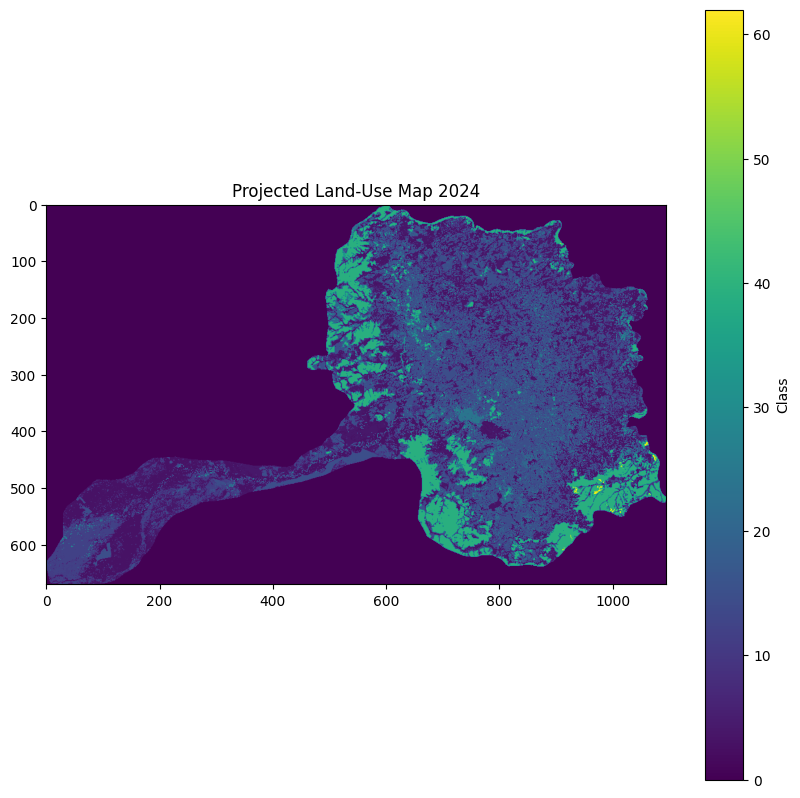

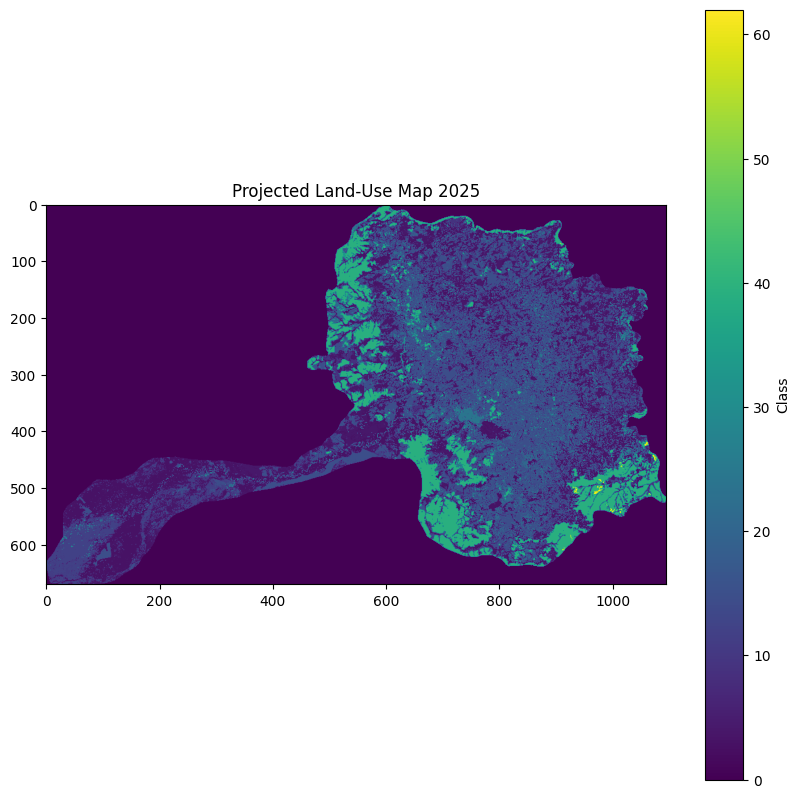

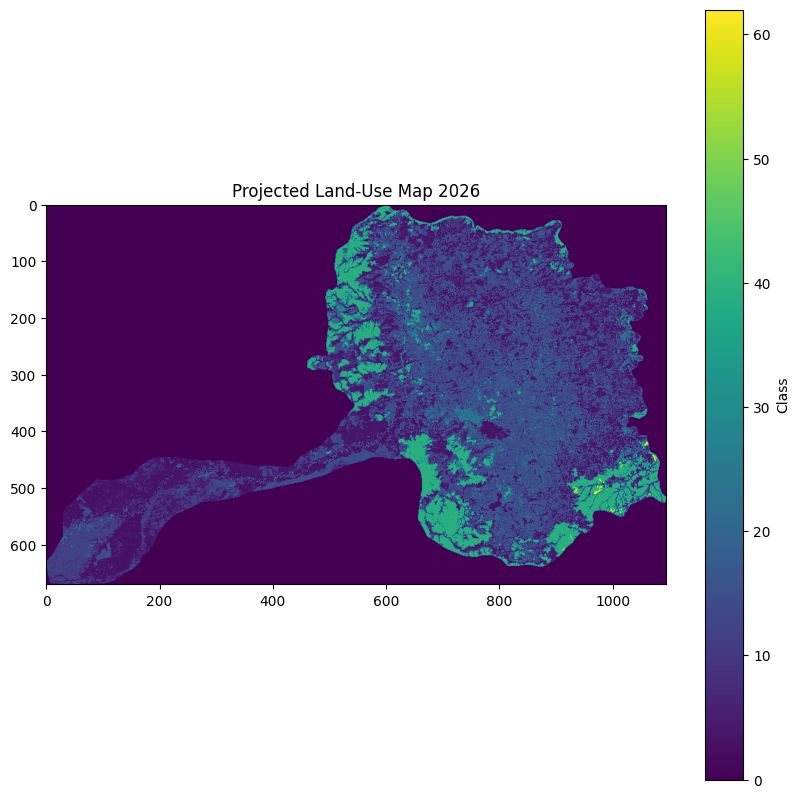

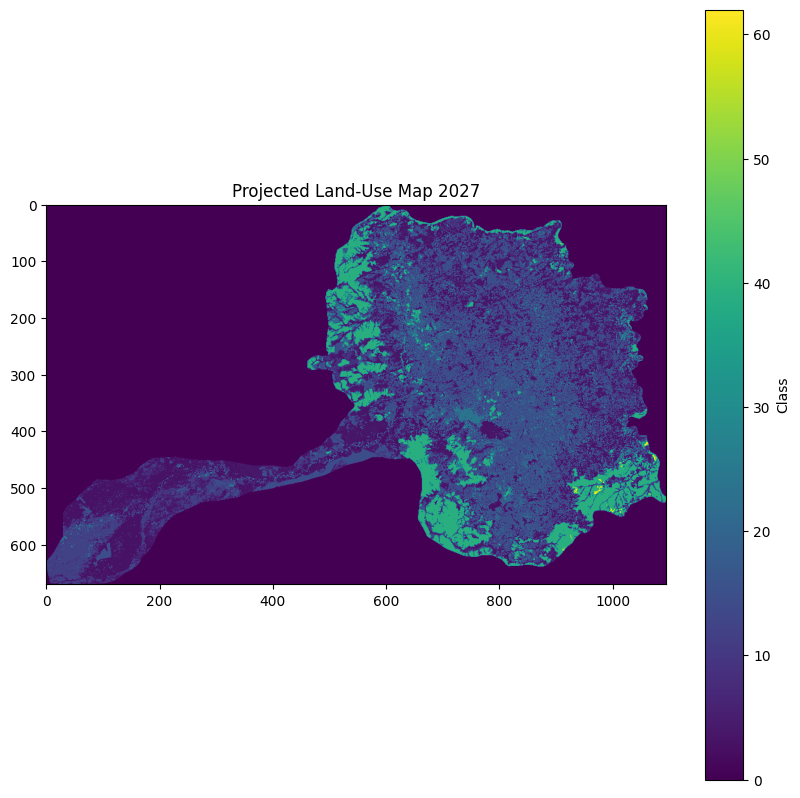

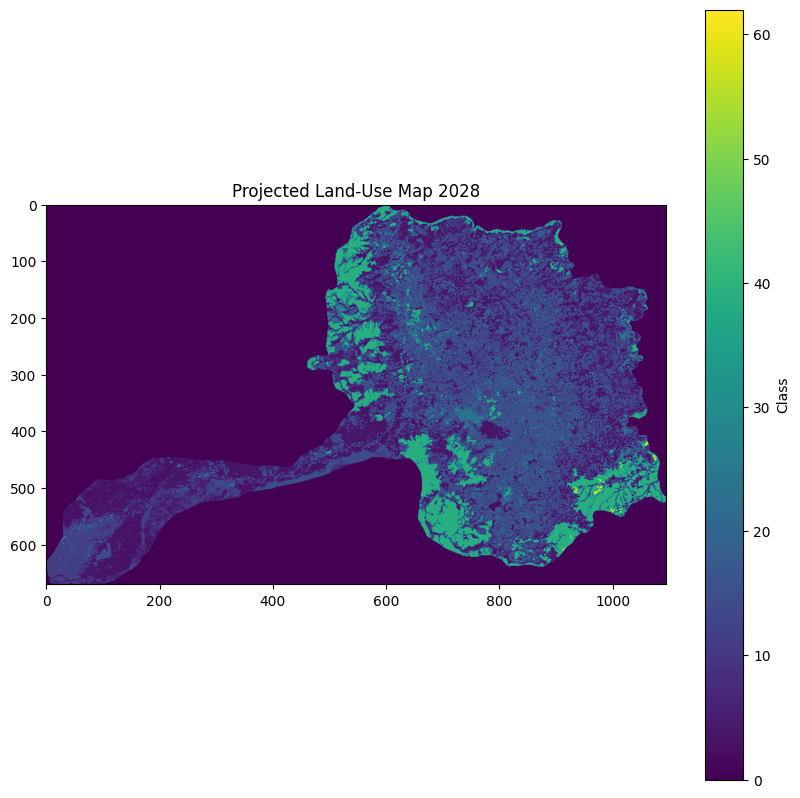

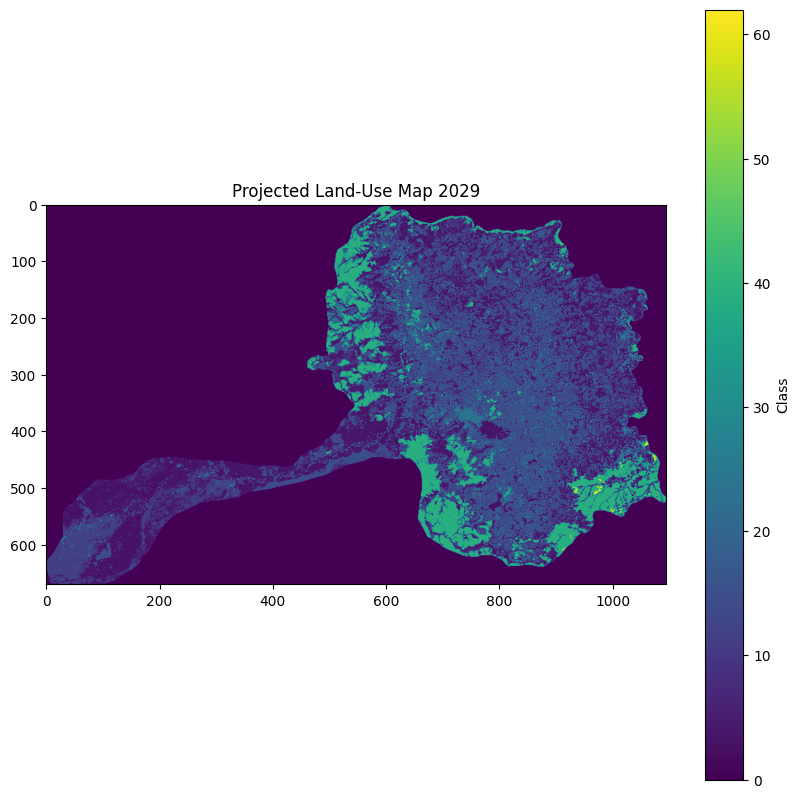

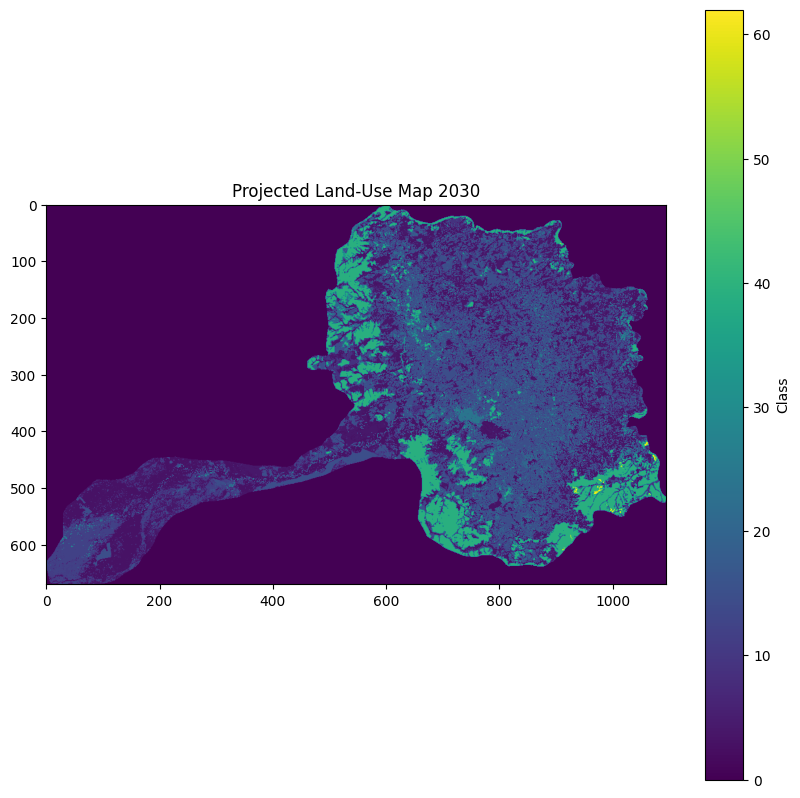

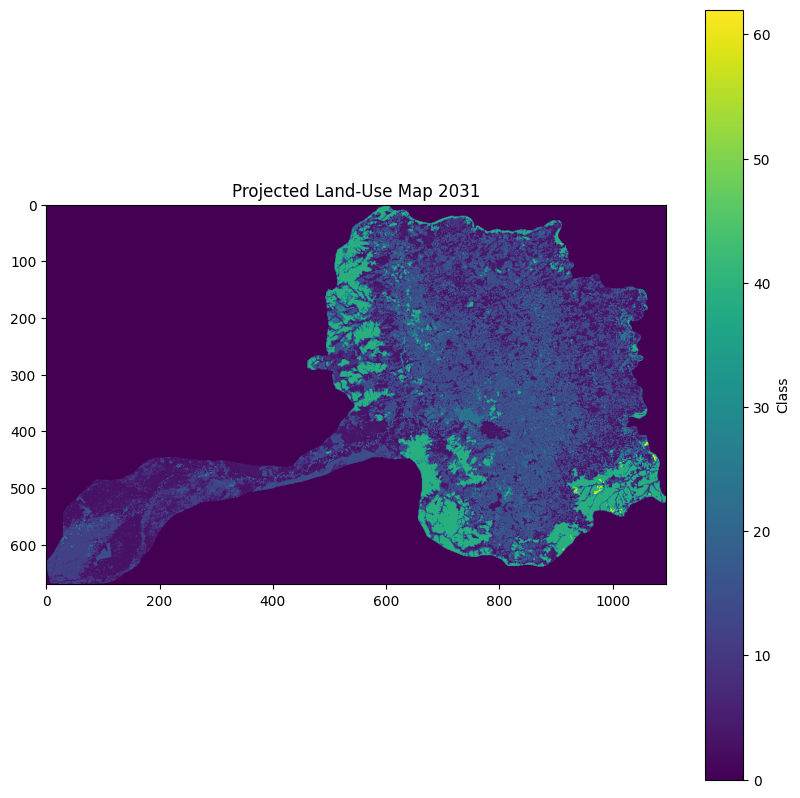

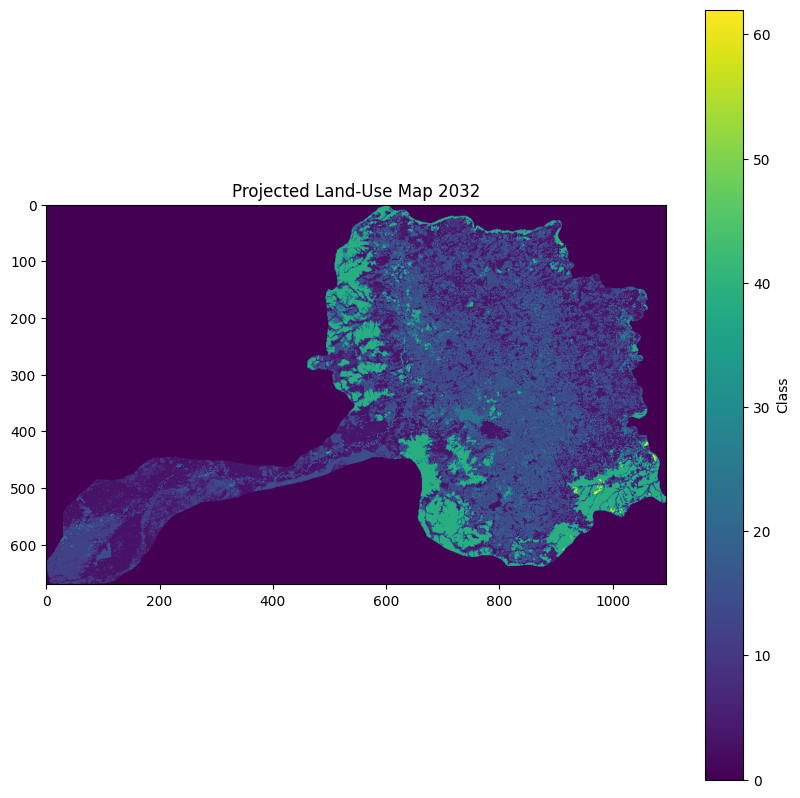

In [119]:
# Load a projected map (e.g., 2024)
FrS_Years = list (range(2024, 2033))

for year in FrS_Years:

    with rasterio.open(f"{OUTPUT_PATH}/{year}.tif") as src:
        projected_map = src.read(1)

    # Plot the projected map
    plt.figure(figsize=(10, 10))
    plt.imshow(projected_map, cmap='viridis')
    plt.colorbar(label='Class')
    plt.title(f"Projected Land-Use Map {year}")
    plt.show()

Class IDs (excluding 0): [3, 4, 9, 11, 12, 15, 21, 24, 25, 29, 33, 39, 41, 62]


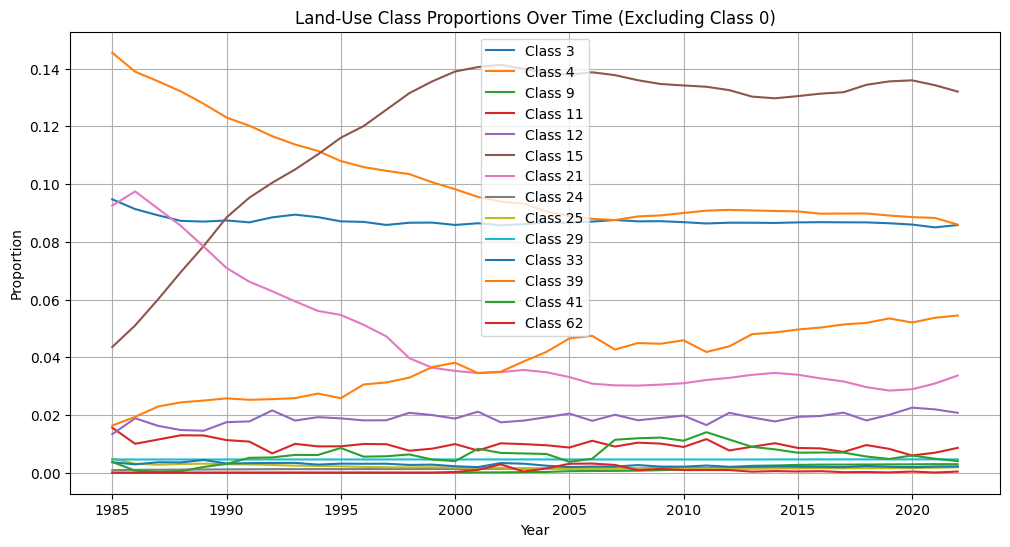

In [ ]:
# Define class_ids based on unique_classes, excluding class 0
class_ids = [cls for cls in unique_classes if cls != 0]  # Exclude class 0
print(f"Class IDs (excluding 0): {class_ids}")

# Calculate class proportions for each year
years = list(range(1985, 2023))  # Historical + projected years
class_proportions = []

for year in years:
    if year <= 2023:
        map_path = f"{DATA_DIR}/{year}.tif"  # Historical maps
    else:
        map_path = f"{OUTPUT_PATH}/{year}.tif"  # Projected maps
    
    with rasterio.open(map_path) as src:
        map_data = src.read(1)
    
    proportions = [np.sum(map_data == cls) / map_data.size for cls in class_ids]
    class_proportions.append(proportions)

class_proportions = np.array(class_proportions)

# Plot trends
plt.figure(figsize=(12, 6))
for i, cls in enumerate(class_ids):
    plt.plot(years, class_proportions[:, i], label=f'Class {cls}')
plt.title('Land-Use Class Proportions Over Time (Excluding Class 0)')
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.legend()
plt.grid(True)
plt.show()